In [2]:
%matplotlib inline
# %matplotlib qt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 250

# import all plotting packages
import matplotlib.pyplot as plt
from matplotlib import colors, cm, patches, animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import gridspec
from matplotlib.colors import LogNorm

# For papers - 
# All figs will be 14 inch for two columns and 7 in for one column


# importing system packages
import os
import sys
import glob
import h5py
import time
import itertools

from tqdm import tqdm

# importing the workhorse
import numpy as np
from numpy.random import default_rng
rng = default_rng()
import pandas as pd
from scipy import io, signal, interpolate, ndimage
from scipy.special import gamma, erf
from skimage import filters
# import seaborn as sns

from sg2d import *

# tiff packages
import tifffile

from lmfit import Minimizer, Parameters, report_fit

from XPCSana import *
from visReduce import *

# from Hao_speckle_utils import *

In [3]:
class nucleus:
    def __init__(self, x_center,y_center,init_rad,index=0,soft_edge=0,growth_rate=1):
        self.xCen=x_center
        self.yCen=y_center
        self.rad=init_rad
        self.soft_edge=soft_edge
        self.growth_rate=growth_rate
        self.index=index

In [4]:
# utils
def genInitNuclei(nSize, xCen, yCen, rCen,soft_edges=None,growth_rates=None):
    x = np.arange(nSize)
    y= np.arange(nSize)
    xx, yy = np.meshgrid(x, y)

    nuclei=[]
    se=soft_edges is None
    gr=growth_rates is None
    
    if se and gr:
        for ind in range(len(rCen)):
            nuclei.append(nucleus(xCen[ind],yCen[ind],rCen[ind],ind))
    elif se and not gr:
        for ind in range(len(rCen)):
            nuclei.append(nucleus(xCen[ind],yCen[ind],rCen[ind],ind,growth_rate=growth_rates[ind]))
    elif not se and gr:
        for ind in range(len(rCen)):
            nuclei.append(nucleus(xCen[ind],yCen[ind],rCen[ind],ind,soft_edge=soft_edges[ind]))
    elif not se and not gr:
        for ind in range(len(rCen)):
            nuclei.append(nucleus(xCen[ind],yCen[ind],rCen[ind],ind,soft_edge=soft_edges[ind],growth_rate=growth_rates[ind]))
            
    return xx,yy,nuclei

def genImgs(nuclei,xx,yy,boundaries=None,soften_edges=None):
    img=np.zeros_like(xx,dtype=float)
    if boundaries is None:
        boundaries=np.zeros_like(img)
    for i in range(len(nuclei)):
        distSq = (xx-nuclei[i].xCen)**2+(yy-nuclei[i].yCen)**2
        img=np.logical_or(distSq<nuclei[i].rad**2,img).astype(float)
        
#     img = img.astype(np.float64) * boundaries.astype(np.float64)
    if soften_edges=='blur':
        img=img.astype(np.float64)
        img=ndimage.gaussian_filter(img,3)
    elif soften_edges=='individual' or soften_edges=='random':
        for i in range(len(nuclei)):
            distSq = (xx-nuclei[i].xCen)**2+(yy-nuclei[i].yCen)**2
            mask= np.logical_and(distSq>=nuclei[i].rad**2,distSq<=(nuclei[i].rad+nuclei[i].soft_edge)**2)
            img[mask]=img[mask]+0.5
        too_large=np.where(img>1.0)
        img[too_large]=1.0
    bnd_row,bnd_col=np.nonzero(boundaries)
    for row,col in zip(bnd_row,bnd_col):
        if img[row,col]>0.5:
            if soften_edges is None:
                img[row,col]=0
            else:
                img[row,col]=0.5
    
    if soften_edges=='random':
        bnd_row,bnd_col=np.nonzero(img==0.5)
        for row,col in zip(bnd_row,bnd_col):
            img[row,col]=np.random.rand()
    return img

def genSpeckle(imgStk,s=None):
    # Generate speckles
    speckle = np.zeros(imgStk.shape)
    
    dim = len(imgStk.shape)

    if dim==2:
        temp = np.fft.fftshift(np.fft.fft2(imgStk,s=s))
        speckle = np.absolute(temp)**2
    elif dim==3:
        temp = np.fft.fftshift(np.fft.fft2(imgStk,s=s),axes=(-2,-1))
        speckle = np.absolute(temp)**2

#     speckle = speckle.astype(np.int32)
    
    return speckle

def growNuclei(nuclei,newGR=None):
    if newGR is None:
        for nuc in nuclei:
            nuc.rad+=nuc.growth_rate
    else:
        for ind,nuc in enumerate(nuclei):
            nuc.rad+=nuc.growth_rate
            nuc.growth_rate=newGR[ind]
        
def produceNucCoords(nuclei):
    xs=[]
    ys=[]
    for nuc in nuclei:
        xs.append(nuc.xCen)
        ys.append(nuc.yCen)
    return np.array(xs),np.array(ys)

In [4]:
def calculateBoundariesRatios_old(nuclei,nSize):
    xx,yy=np.meshgrid(np.arange(nSize),np.arange(nSize))
    xx,yy=xx.astype(np.float64),yy.astype(np.float64)
    ratios=np.zeros((nSize,nSize),dtype=np.float64)
    pair_index=ratios.copy()
    for col in range(nSize):
        for row in range(nSize):
            dists=np.zeros((len(nuclei),))
            for ind,nuc in enumerate(nuclei):
                dists[ind]=(xx[row,col]-nuc.xCen)**2+(yy[row,col]-nuc.yCen)**2
            order=np.argsort(dists)
    #         print(dists[0]/dists[1])
            ratios[row,col]=(dists[order[1]]-dists[order[0]])/((nuclei[order[1]].xCen-nuclei[order[0]].xCen)**2+(nuclei[order[1]].yCen-nuclei[order[0]].yCen)**2)
            pair_index[row,col]=(nuclei[order[1]].index+nuclei[order[0]].index)/np.abs(nuclei[order[1]].index-nuclei[order[0]].index)
    
    return ratios,pair_index

In [5]:
def calculateBoundariesRatios(nuclei,nSize):
    xx,yy=np.meshgrid(np.arange(nSize).astype(np.float64),np.arange(nSize).astype(np.float64))
    ratios=np.ones((nSize,nSize),dtype=np.float64)
    pair_index=ratios.copy()
    d1=ratios.copy()*np.inf
    d2=ratios.copy()*np.inf
    n1=np.zeros_like(d1)
    n2=np.zeros_like(d2)
    old_d=np.ones_like(ratios)*np.inf
    old_n=-1
    for ind,nuc in enumerate(nuclei):
        d=(xx-nuc.xCen)**2+(yy-nuc.yCen)**2
        d1_inds=d<d1
        d2_inds=np.logical_and(d>=d1,d<=d2)
        d1[d1_inds]=d[d1_inds]
        n1[d1_inds]=nuc.index
        d2[d1_inds]=old_d[d1_inds]
        n2[d1_inds]=old_n
        d2[d2_inds]=d[d2_inds]
        n2[d2_inds]=nuc.index
        old_d=d.copy()
        old_n=nuc.index
#         fig,axis=plt.subplots(1,2)
#         axis[0].imshow(d1,origin='lower')
#         axis[1].imshow(d2,origin='lower')
    ratios=(d2-d1)/(d2+d1)
    pair_index=((n1+n2)+np.abs(n1-n2))*((n1+n2)+np.abs(n1-n2)+1)/2+(n1+n2)
#     plt.figure()
#     plt.imshow(ratios,origin='lower')
    
    return ratios,pair_index

def chooseFixedRegions(boundaries,fraction):
    if fraction>1:
        print('choose a valid fraction<1')
        return
    ravelled_bound_in=np.where(boundaries.ravel())[0]
    ravelled_fixed_pixels=np.random.choice(ravelled_bound_in,int(fraction*len(ravelled_bound_in)))
    return np.unravel_index(ravelled_fixed_pixels,boundaries.shape)

In [6]:
def long_tail_sampling_conversion(uniforms,alpha,tau):
    return tau*((-uniforms+1)**(-1/alpha)-1)

def long_tail_dist(ts,alpha,tau):
    if alpha>0:
        return alpha/(tau*(1+(ts/tau))**(alpha+1))
    else:
        return np.zeros_like(ts)
    
def long_tail_dist_cdf(ts,alpha,tau):
    if alpha>0:
        return -1*(ts/tau+1)**-alpha+1
    else:
        return np.zeros_like(ts)

In [ ]:
xCen,yCen=[14,44,30,20],[7,22,44,38]
xx,yy,nuclei=genInitNuclei(50,xCen,yCen,[2,2,2,2])
img=genImgs(nuclei,xx,yy)
ratios=np.ones((50,50))
d1=ratios.copy()*np.inf
d2=ratios.copy()*np.inf
n1=np.zeros_like(d1)
n2=np.zeros_like(d2)
old_d=np.ones_like(ratios)*np.inf
old_n=-1
for nuc_test in range(len(nuclei)):
    d=(xx-nuclei[nuc_test].xCen)**2+(yy-nuclei[nuc_test].yCen)**2
    d1_inds=d<d1
    d2_inds=np.logical_and(d>=d1,d<=d2)
    d1[d1_inds]=d[d1_inds]
    n1[d1_inds]=nuclei[nuc_test].index
    d2[d1_inds]=old_d[d1_inds]
    n2[d1_inds]=old_n
    d2[d2_inds]=d[d2_inds]
    n2[d2_inds]=nuclei[nuc_test].index
    old_d=d.copy()
    old_n=nuclei[nuc_test].index
fig,axes=plt.subplots(1,5)
axes[0].imshow(d,origin='lower',cmap='brg')
axes[0].scatter(xCen,yCen,color='red')
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].imshow(d1,origin='lower',cmap='brg')
axes[1].scatter(xCen,yCen,color='red')
axes[1].set_xticks([])
axes[1].set_yticks([])

axes[2].imshow(d2,origin='lower',cmap='brg')
axes[2].scatter(xCen,yCen,color='red')
axes[2].set_xticks([])
axes[2].set_yticks([])

axes[3].imshow(n1,origin='lower',cmap='Accent',vmin=0,vmax=len(nuclei)-1)
axes[3].scatter(xCen,yCen,color='black')
axes[3].set_xticks([])
axes[3].set_yticks([])

image=axes[4].imshow(n2,origin='lower',cmap='Accent',vmin=0,vmax=len(nuclei)-1)
axes[4].scatter(xCen,yCen,color='black')
axes[4].set_xticks([])
axes[4].set_yticks([])
plt.colorbar(image)

ratios= (d2-d1)/(d2+d1)
pair_index=((n1+n2)+np.abs(n1-n2))*((n1+n2)+np.abs(n1-n2)+1)/2+(n1+n2)
bndy=ratios<0.2
plt.figure()
plt.imshow(bndy,origin='lower')
plt.colorbar()
plt.figure()
plt.imshow(pair_index,origin='lower',cmap='Dark2',vmin=0)
# plt.colorbar()

# plt.figure()
# plt.imshow(pair_index*bndy,origin='lower',cmap='gist_rainbow')
# plt.colorbar()

displayImg(pair_index*bndy)
displayImg(n1,titleStr='nearest')
displayImg(n2,titleStr='next nearest')

print(np.unique(pair_index))

In [42]:
# inds=chooseFixedRegions(boundaries,0.2)
# test=np.zeros_like(boundaries)
# test[inds]=True
# displayImg(np.array(test,dtype=float))
print(np.sum(rng.poisson(rate**-1,grow_time))/np.sqrt(250))
print(np.concatenate((1+np.floor(np.linspace(0,grow_time,nSteps_growth)),1+grow_time+np.logspace(2,np.log10(anneal_time),nSteps_anneal))))
print(rate)

3994.1464214522734
[1.00000000e+00 2.10000000e+01 4.10000000e+01 6.10000000e+01
 8.10000000e+01 1.01000000e+02 1.21000000e+02 1.41000000e+02
 1.61000000e+02 1.81000000e+02 2.01000000e+02 2.21000000e+02
 2.41000000e+02 2.61000000e+02 2.81000000e+02 3.01000000e+02
 3.21000000e+02 3.41000000e+02 3.61000000e+02 3.81000000e+02
 4.01000000e+02 4.21000000e+02 4.41000000e+02 4.61000000e+02
 4.81000000e+02 5.01000000e+02 5.21000000e+02 5.41000000e+02
 5.61000000e+02 5.81000000e+02 6.01000000e+02 6.21000000e+02
 6.41000000e+02 6.61000000e+02 6.81000000e+02 7.01000000e+02
 7.21000000e+02 7.41000000e+02 7.61000000e+02 7.81000000e+02
 8.01000000e+02 8.21000000e+02 8.41000000e+02 8.61000000e+02
 8.81000000e+02 9.01000000e+02 9.21000000e+02 9.41000000e+02
 9.61000000e+02 9.81000000e+02 1.00100000e+03 1.10100000e+03
 1.13903843e+03 1.19154607e+03 1.26402680e+03 1.36407805e+03
 1.50218723e+03 1.69283097e+03 1.95599259e+03 2.31925674e+03
 2.82070086e+03 3.51288643e+03 4.46836850e+03 5.78730092e+03
 7.60

## Growth only

In [7]:
# Defining the parameters
nCen = 1000 # Number of nucleus
nSize = 500 # Field of view
nSteps_growth = 51 # Steps
grow_time=1000
nSteps_anneal= 51
anneal_time=1e9
timeSteps=np.concatenate((1+np.floor(np.linspace(0,grow_time,nSteps_growth)),1+grow_time+np.logspace(2,np.log10(anneal_time),nSteps_anneal)))
nChange = 4 # Number of nucleus changed
iniR = 4 # Initial max nucleaus size
rate = np.sqrt((nSize**2)/nCen)/grow_time # Growth rate
newCen = 0 # New centers
ROI_min=2
ROI_max=10
boundary_thres_start=0.05

In [378]:
ravelCen=rng.choice(np.arange(nSize**2),size=nCen,replace=False)
xCen,yCen=np.unravel_index(ravelCen,shape=(nSize,nSize))

rCen = rng.integers(3, high=iniR+1, size=nCen)
save_starting_cond=False
if save_starting_cond:
    np.savez('starting_nuc_pos_rad_test2.npz',xCen=xCen,yCen=yCen,rCen=rCen)

In [405]:
#create new list of starting positions
save_list=False
num_configs=2000
xCens=np.zeros((num_configs,nCen))
yCens=np.zeros_like(xCens)
rCens=np.zeros_like(xCens)
for k in range(num_configs):
    ravelCen=rng.choice(np.arange(nSize**2),size=nCen,replace=False)
    xCen,yCen=np.unravel_index(ravelCen,shape=(nSize,nSize))
    rCen=rng.integers(3,high=iniR+1,size=nCen)
    xCens[k,:]=xCen
    yCens[k,:]=yCen
    rCens[k,:]=rCen
if save_list:
    np.savez('starting_nuc_pos_rad_list_1000-nuc_500-size.npz',xCenArray=xCens,yCenArray=yCens,rCenArray=rCens)

In [8]:
starting_dict=np.load('starting_nuc_pos_rad.npz')
xCen,yCen,rCen=starting_dict['xCen'],starting_dict['yCen'],starting_dict['rCen']

In [9]:
# xCen = np.random.randint(0, high=nSize, size=nCen)
# yCen = np.random.randint(0, high=nSize, size=nCen)


# xCen=np.array([nSize//2-1])
# yCen=xCen.copy()
# rCen=np.array([iniR])

imgStk = []

# First img
# uniform_grow_rate=rate*np.ones_like(rCen)
# soft_edges=np.array([2.0 for k in range(nCen)],dtype=float)
# xx,yy,nuclei=genInitNuclei(nSize, xCen, yCen, rCen,growth_rates=uniform_grow_rate,soft_edges=soft_edges)

# grow_rates=rng.normal(rate,rate/1.2,size=rCen.shape)
# xx,yy,nuclei=genInitNuclei(nSize, xCen, yCen, rCen,growth_rates=grow_rates)

# grow_rates=rng.randint(0,rate+1,size=rCen.shape)+0.5
# grow_rates=rng.choice([0,rate],size=rCen.shape)
# print(grow_rates)
# soft_edges=np.array([2.0 for k in range(nCen)],dtype=float)
# xx,yy,nuclei=genInitNuclei(nSize, xCen, yCen, rCen,growth_rates=grow_rates,soft_edges=soft_edges)

num_nuclei_grow=rng.poisson(rate**-1,grow_time+1)
grow_rates=np.zeros_like(rCen)
grow_rates[rng.choice(np.arange(nCen),size=num_nuclei_grow[0],replace=False)]=1
print(num_nuclei_grow.shape)
t_start=time.time()
xx,yy,nuclei=genInitNuclei(nSize, xCen, yCen, rCen,growth_rates=grow_rates)
print('done generating initial nuclei ', time.time()-t_start)
img = genImgs(nuclei, xx,yy)
# plt.pcolormesh(xx,yy,img,cmap='Greys')
# plt.colorbar()
imgStk.append(img)
print('calculating pixel ratios')
# t_start=time.time()
# pixel_boundary_ratios,pair_index=calculateBoundariesRatios_old(nuclei,nSize)
# plt.imshow(pixel_boundary_ratios,origin='lower',norm=LogNorm())
# print('done calculating pixel ratios the old way in ', time.time()-t_start)
t_start=time.time()
pixel_boundary_ratios,pair_index=calculateBoundariesRatios(nuclei,nSize)
print('done calculating pixel ratios the new way in ', time.time()-t_start)
boundaries=pixel_boundary_ratios<boundary_thres_start
# boundaries=None
# Start evolution
prev_time=0
for j in tqdm(range(nSteps_growth)):
    for timeStep in np.arange(prev_time,timeSteps[j]):
        new_grow_rates=np.zeros_like(rCen)
        new_grow_rates[rng.choice(np.arange(nCen),size=num_nuclei_grow[j],replace=False)]=1
     # Growth
    # new_grow_rates=rng.normal(rate,rate/1.2,size=rCen.shape)
#     new_grow_rates=np.random.randint(0,rate+1,size=rCen.shape)+0.5
#     new_grow_rates=np.random.choice([0,rate],size=rCen.shape)
#     new_grow_rates=None
        growNuclei(nuclei,newGR=new_grow_rates)
    prev_time=timeSteps[j]
    # print(prev_time)
    # # Nucleation
    # xCen = np.hstack((xCen, np.random.randint(0, high=nSize, size=newCen)))
    # yCen = np.hstack((yCen, np.random.randint(0, high=nSize, size=newCen)))
    # rCen = np.hstack((rCen, np.random.randint(1, high=iniR+1, size=newCen)))

    img = genImgs(nuclei,xx,yy,boundaries,soften_edges=None)
    imgStk.append(img)

# print(len(imgStk))
# imgStk = np.array(imgStk)
# xpcsStk = np.array(xpcsStk)

(1001,)
done generating initial nuclei  0.003998517990112305
calculating pixel ratios
done calculating pixel ratios the new way in  3.811418294906616


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [01:55<00:00,  2.26s/it]


"anneal" step

In [18]:
boundary_thres_final=0.01
anneal_alpha=0.8615681292179102
# anneal_tau=nSteps_anneal/(10**(1/anneal_alpha)-1)
anneal_tau=140182.62457056605
# anneal_alpha=np.log10(nSteps_anneal/anneal_tau+1)**-1
final_bndys=pixel_boundary_ratios<boundary_thres_final
padLen=(500,500)

In [19]:
border_inds=np.unique(pair_index)
border_anneal_times=long_tail_sampling_conversion(rng.random(border_inds.shape),anneal_alpha,anneal_tau)
# border_anneal_times=rng.poisson(anneal_tau,border_inds.shape)
# vals,bins,art=plt.hist(border_anneal_times,100)
# cdf=np.array([np.sum(border_anneal_times<(k+1)) for k in range(nSteps_anneal)])
# plt.plot(cdf)
prev_time=0
percent_anneal_per_timestep=[]
for step in tqdm(range(nSteps_anneal)):
    timeStep=timeSteps[nSteps_growth+step]
    convert_pair_inds=border_inds[np.where(np.logical_and(border_anneal_times>prev_time,border_anneal_times<=timeStep))]
#     print(len(convert_pair_inds))
    img=imgStk[-1].copy()
    percent_anneal_per_timestep.append(convert_pair_inds.shape[0]/border_inds.shape[0])
    for ind in convert_pair_inds:
        change_region=np.where(pair_index==ind)
        img[change_region]=np.logical_not(final_bndys[change_region])
    imgStk.append(img)
    prev_time=timeStep

imgStk=np.array(imgStk)
xpcsStk=genSpeckle(imgStk,s=padLen)

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:02<00:00, 17.51it/s]


figure save location

In [20]:
# foldername='cell auto results/{}nucs_{}size_{}grow_{}longtail-anneal_arb-timesteps_{:.2E}rate-markov_hard'.format(nCen,nSize,nSteps_growth,nSteps_anneal,rate)
foldername='cell auto results/paper-figs'
if not os.path.isdir(foldername):
    os.makedirs(foldername)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


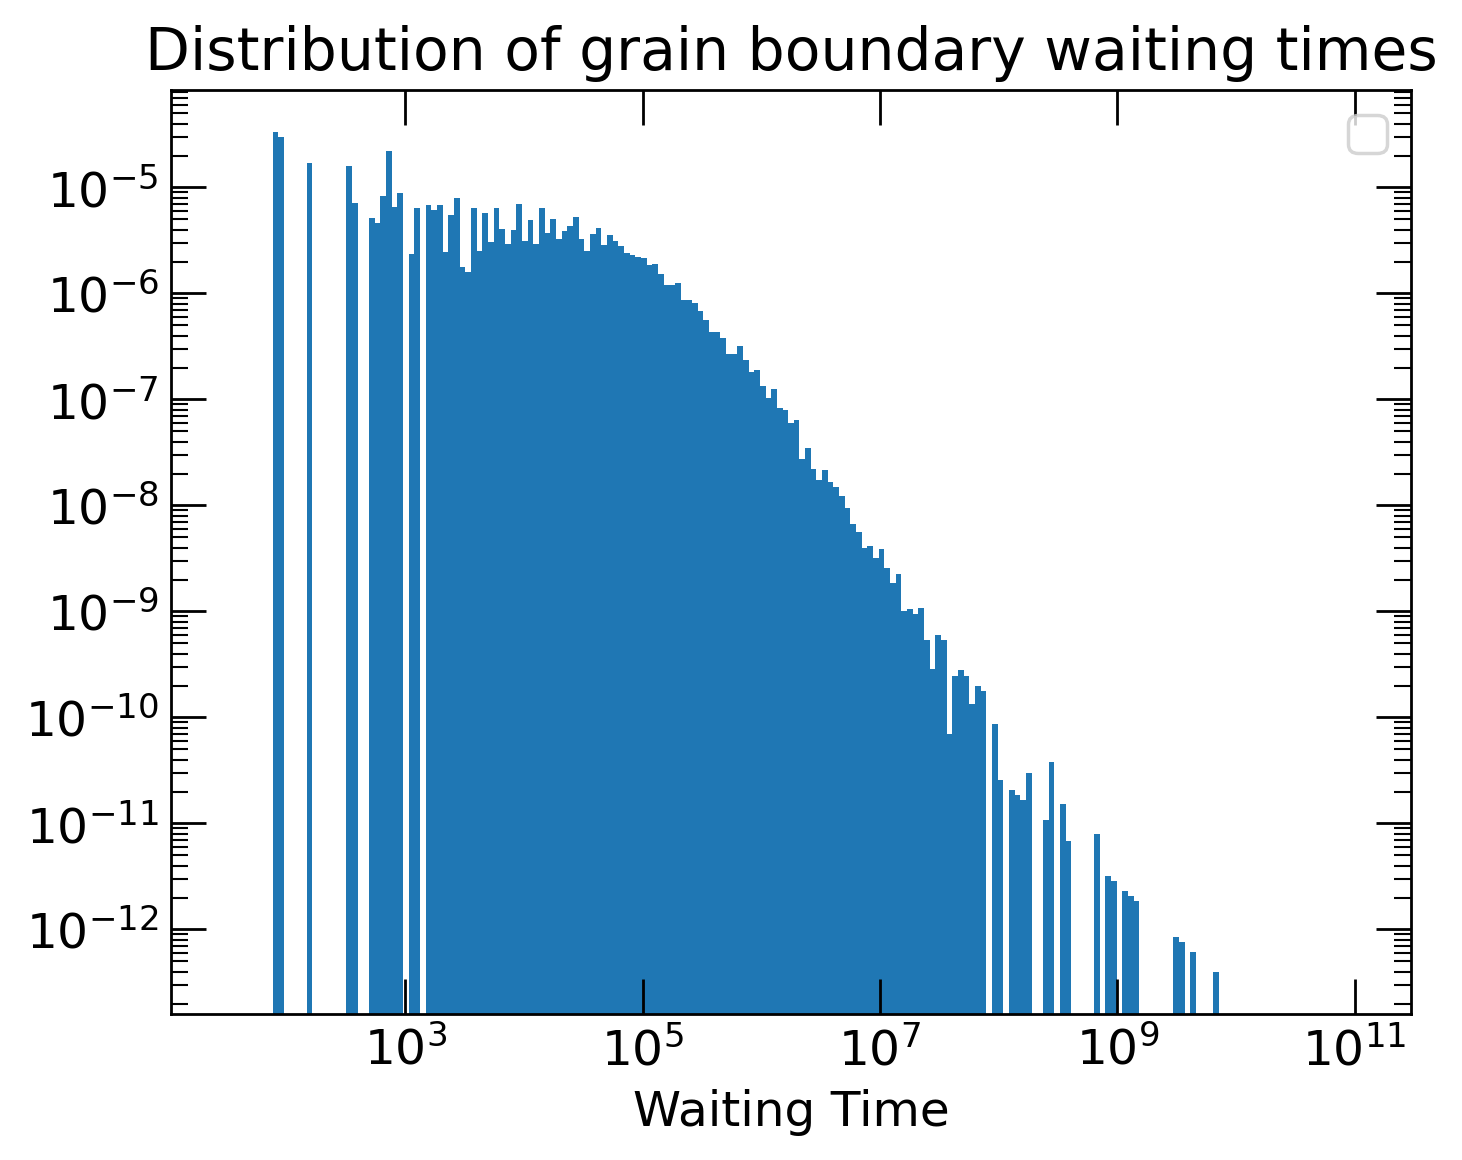

In [24]:
left_edges=np.logspace(1.5, 11,200)
vals, bins, artists=plt.hist(border_anneal_times,left_edges,density=True)
# plt.plot(left_edges,long_tail_dist(left_edges,anneal_alpha,anneal_tau),color='red',linewidth=1.5,label='theoretical distribution')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Waiting Time')
# plt.ylabel('Probability Density')
plt.title('Distribution of grain boundary waiting times')
# plt.text(600,3e-3,'N={}'.format(len(border_inds)))
plt.legend()
# plt.savefig(os.path.join(foldername,'alpha{:.2f}-tau{:.2f}_wait-time-hist.svg'.format(anneal_alpha,anneal_tau)))
# plt.xscale('log')

([], [])

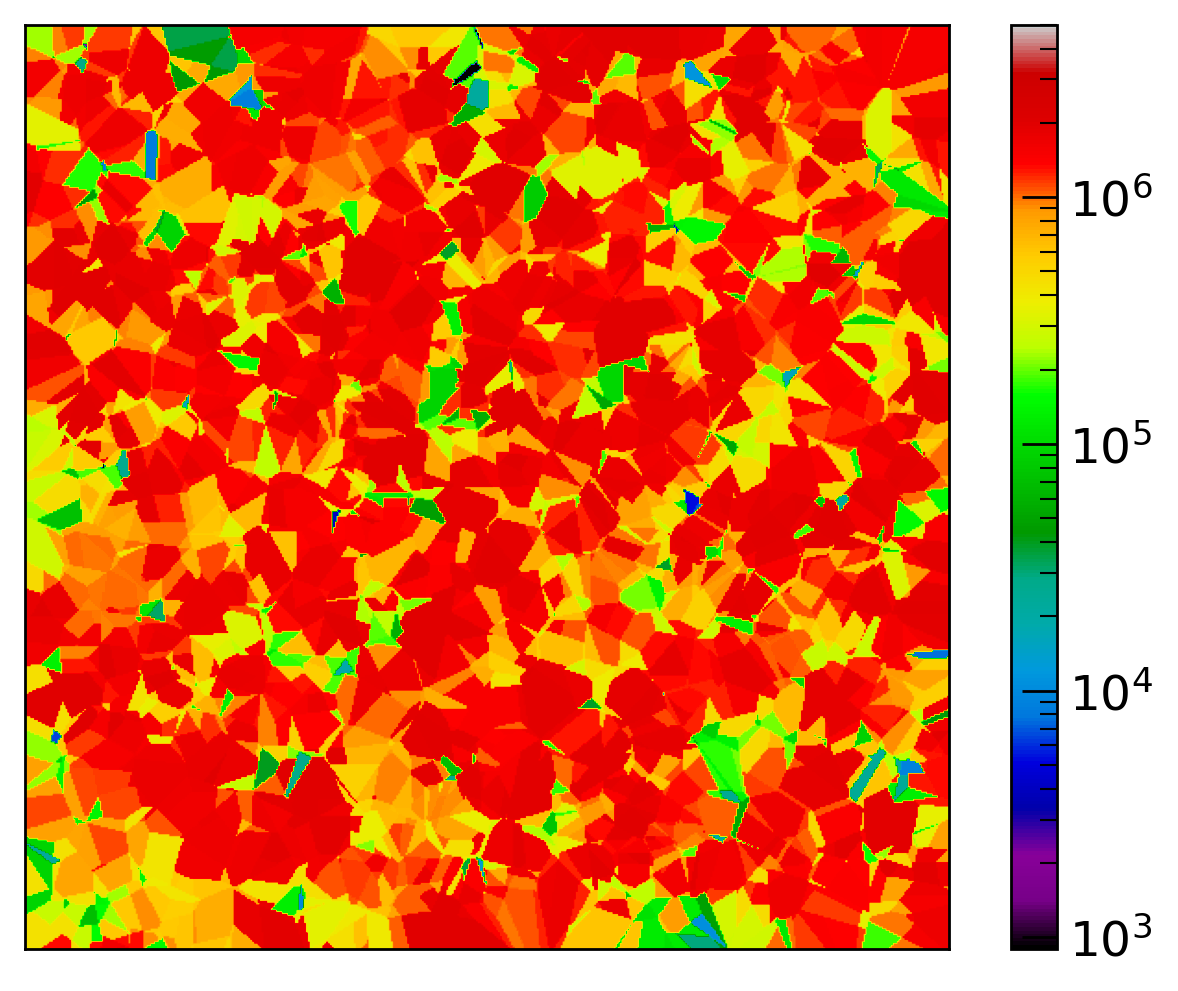

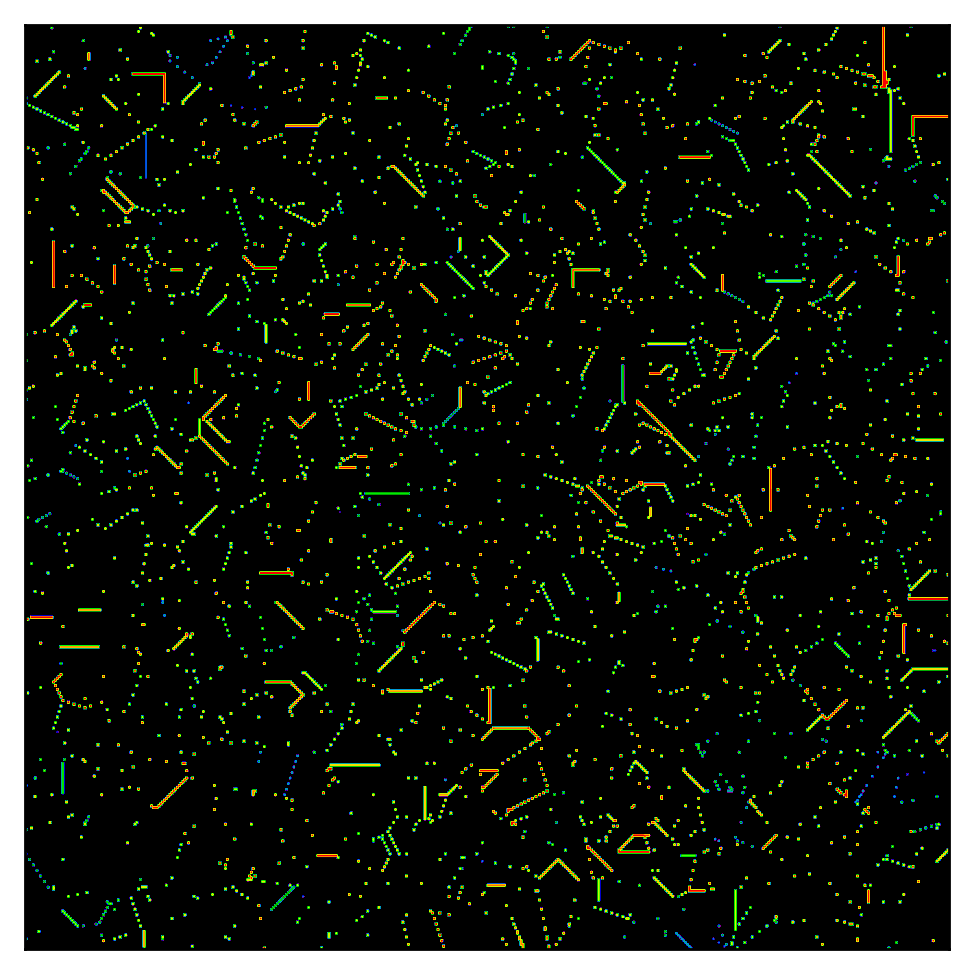

In [26]:
# plt.figure()
# plt.imshow(boundaries,origin='lower')
# xCens,yCens=produceNucCoords(nuclei)
# plt.figure()
# plt.imshow(final_bndys,origin='lower')
# xCens,yCens=produceNucCoords(nuclei)
# plt.scatter(xCens,yCens)
# plt.figure()
# plt.imshow(pixel_boundary_ratios>boundary_thres_start,origin='lower')
# xCens,yCens=produceNucCoords(nuclei)
# plt.scatter(xCens,yCens)
# plt.figure()
# plt.imshow(pair_index*boundaries.astype(np.float64),origin='lower',cmap='CMRmap',norm=LogNorm())
# plt.colorbar()
# plt.scatter(xCens,yCens)
# print(np.unique(pair_index))
plt.figure()
plt.imshow(pair_index,origin='lower',cmap='nipy_spectral',norm=LogNorm(vmin=9e2,vmax=5e6))
plt.tick_params('both',which='both',left=False,right=False,top=False,bottom=False)
plt.xticks([])
plt.yticks([])
plt.colorbar()
# plt.savefig(os.path.join(foldername,'pair_index_initial.png'))

plt.figure()
plt.imshow(pair_index*final_bndys.astype(np.float64)+1.0,origin='lower',cmap='nipy_spectral',norm=LogNorm(vmin=9e2,vmax=5e6))
plt.tick_params('both',which='both',left=False,right=False,top=False,bottom=False)
plt.xticks([])
plt.yticks([])
# plt.savefig(os.path.join(foldername,'pair_index_final.png'))

# plt.imshow(pixel_boundary_ratios,origin='lower',cmap='brg',norm=LogNorm())
# plt.colorbar()
# plt.scatter(xCens,yCens)
# print([(n.index,n.xCen,n.yCen) for n in nuclei])

In [28]:
ratio_fft=np.fft.fftshift(np.fft.fft2(boundaries))
displayImg(np.abs(ratio_fft),colorScale='log',vmax=3e3)
print(xpcsStk.shape)

Loading BokehJS ...

(103, 500, 500)


[0.00000000e+00 8.10000000e+01 2.21000000e+02 2.31925674e+03
 1.00000100e+09]


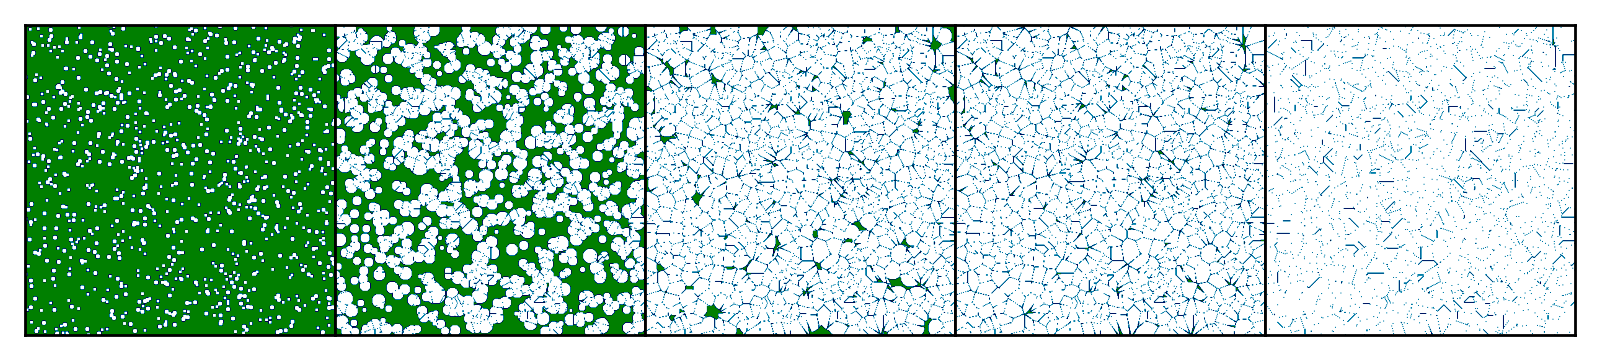

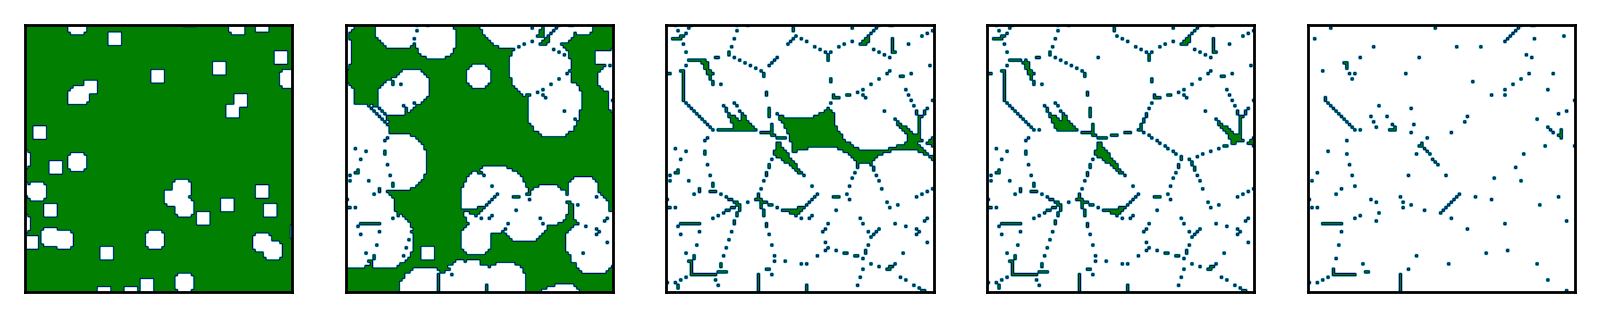

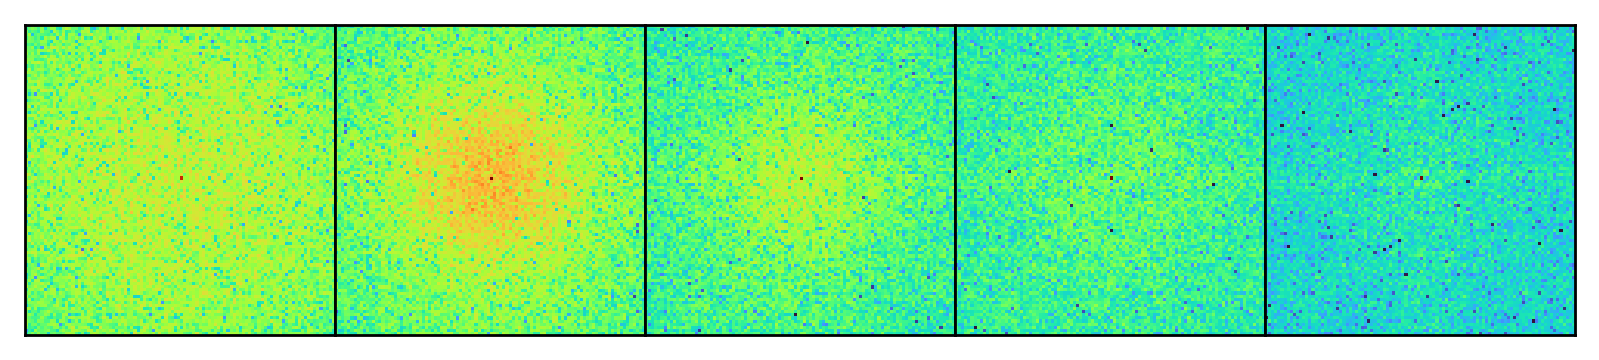

In [148]:
mpl.rcParams['figure.dpi'] = 250
mpl.rcParams['pcolor.shading'] = 'auto'
# t_inds=[0,9,20,60,70,92]
t_inds=[0,5,12,60,102]
full_tsteps=np.concatenate(([0],timeSteps))
print(full_tsteps[t_inds])
fig, ax = plt.subplots(1, len(t_inds),figsize=(8,4))
plt.subplots_adjust(wspace=0,hspace=0)
for ind in range(len(t_inds)):
    ax[ind].imshow(imgStk[t_inds[ind]],vmin=0,vmax=1,origin='lower',cmap='ocean')
    ax[ind].set_xticks([])
    ax[ind].set_yticks([])
    # ax[0,ind].set_title('t={:n}'.format(full_tsteps[t_inds[ind]]))
plt.savefig(os.path.join(foldername,f'alpha{anneal_alpha:.2f}-tau{anneal_tau:.1e}_real-space-t-series.png'))

fig, ax = plt.subplots(1, len(t_inds),figsize=(8,4))
# plt.subplots_adjust(wspace=0,hspace=0)
for ind in range(len(t_inds)):
    ax[ind].imshow(imgStk[t_inds[ind],25:125,350:450],vmin=0,vmax=1,origin='lower',cmap='ocean')
    ax[ind].set_xticks([])
    ax[ind].set_yticks([])
    # ax[0,ind].set_title('t={:n}'.format(full_tsteps[t_inds[ind]]))
# plt.savefig(os.path.join(foldername,'alpha{}-tau{:.1e}_real-space-t-series_zoom1.png'.format(anneal_alpha,anneal_tau)))

zoom_half_size=50
fig, ax = plt.subplots(1, len(t_inds),figsize=(8,4))
speckle_imgs=xpcsStk[t_inds,(xpcsStk.shape[1]//2-zoom_half_size):(xpcsStk.shape[1]//2+zoom_half_size),
(xpcsStk.shape[2]//2-zoom_half_size):(xpcsStk.shape[2]//2+zoom_half_size)]
speckle_ints=np.sum(speckle_imgs,axis=(1,2))
vmins=[100,100,250,250,250]
vmaxs=[1e8,1e8,1e7,5e5,5e5]
plt.subplots_adjust(wspace=0,hspace=0)
for ind in range(len(t_inds)):
    # speckle_img=xpcsStk[t_inds[ind],(250-zoom_half_size):(250+zoom_half_size),(250-zoom_half_size):(250+zoom_half_size)]
    speckle_img=speckle_imgs[ind]
    ax[ind].imshow(speckle_img,
                   # norm=LogNorm(vmin=vmins[ind],vmax=vmaxs[ind]),
                   norm=LogNorm(vmin=10,vmax=1e10),
                   # norm=LogNorm(),
                   # norm=LogNorm(1e-10,5e-2),
                   # norm=LogNorm(vmin=np.percentile(speckle_img,vmins[ind]),vmax=np.percentile(speckle_img,90.0)),
                   # vmin=0.5,vmax=2,
                   cmap='turbo',origin='lower'
                  )
    ax[ind].set_xticks([])
    ax[ind].set_yticks([])
    # ax[ind].set_title('{:.1e}'.format(full_tsteps[t_inds[ind]]))
plt.savefig(os.path.join(foldername,f'alpha{anneal_alpha:.2f}-tau{anneal_tau:.1e}_paper-q-t-series_zoom1.png'))

In [25]:
def azimuthal_average(speckle,binsize=1):
    center=np.unravel_index(np.argmax(speckle),speckle.shape)
    x,y=np.meshgrid(np.arange(speckle.shape[1]),np.arange(speckle.shape[0]))
    radius=np.sqrt((x-center[1])**2+(y-center[0])**2)
    bins=np.arange(0,np.sqrt(speckle.shape[0]**2+speckle.shape[1]**2),binsize)
    dig=np.digitize(radius,bins=bins)
    avgs=np.zeros_like(bins)
    for ind in np.unique(dig):
        avgs[ind]=np.nanmean(speckle[np.where(dig==ind)])
    return bins,avgs

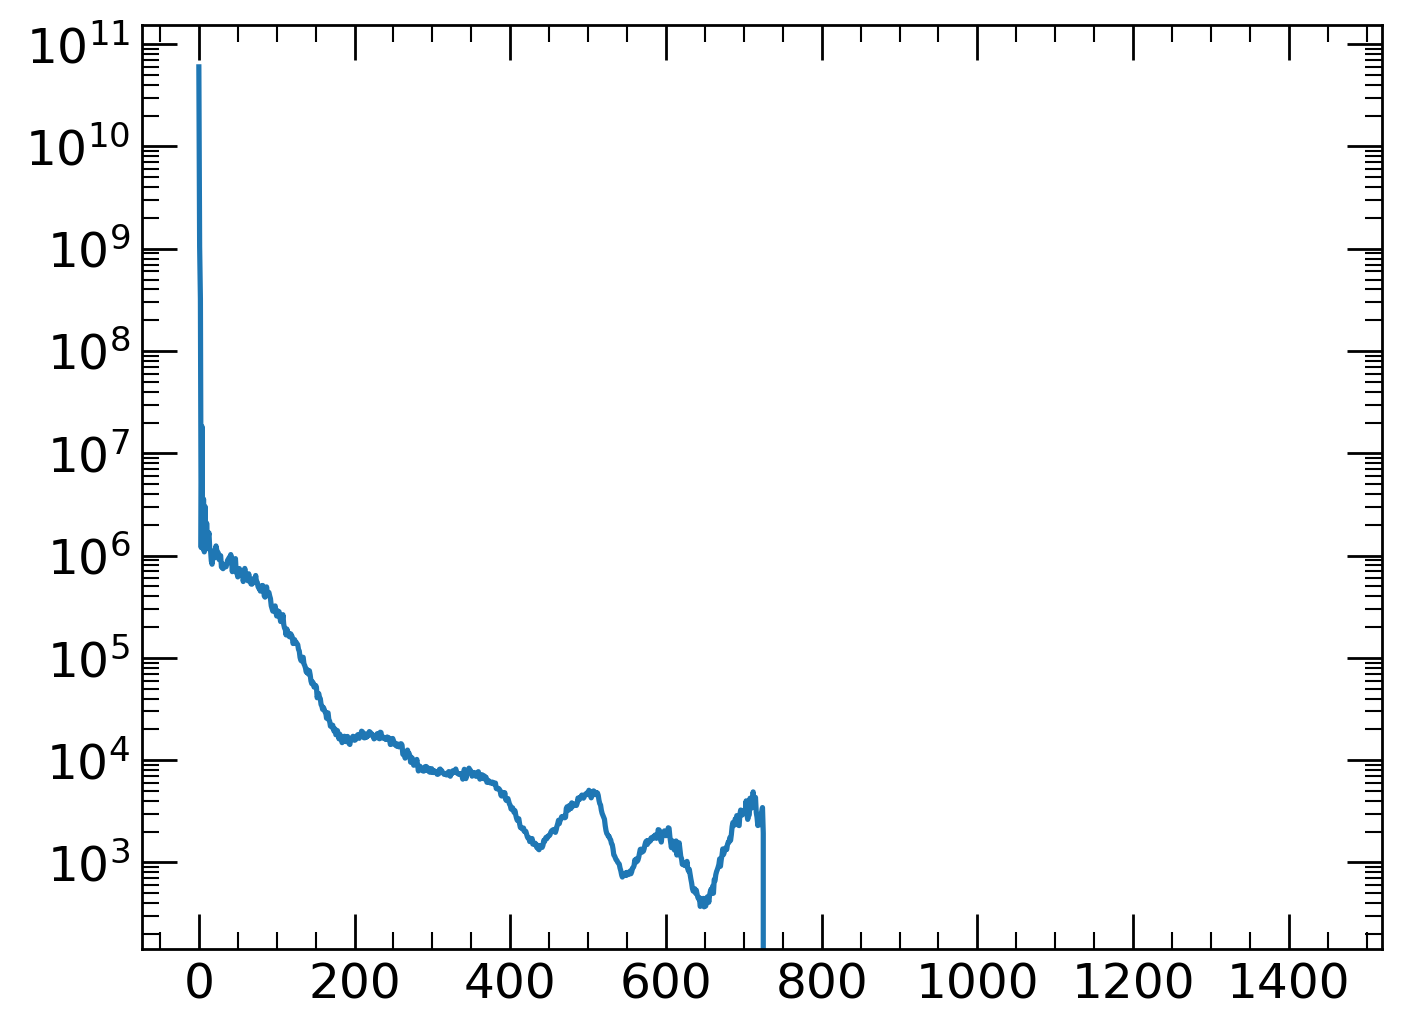

In [35]:
b,a=azimuthal_average(xpcsStk[0],binsize=1)
a[0]=np.max(xpcsStk)
plt.figure()
plt.semilogy(b,a)

array([[ 4761.        ,  5265.48211689, 14177.28740362, ...,
        12088.22764997, 14177.28740362,  5265.48211689],
       [  579.91615555,  1628.15762663,  3959.72722225, ...,
         7969.73278786,  6247.74294672,  3736.83590955],
       [26346.76149077, 10100.98320341,  2004.38438161, ...,
         3326.87161451,   356.23111249, 38519.0331417 ],
       ...,
       [  578.94087373,  5166.89164038,  2844.73980136, ...,
         5420.22373649,   968.31095603, 11579.87984865],
       [26346.76149077, 38519.0331417 ,   356.23111249, ...,
         9986.774324  ,  2004.38438161, 10100.98320341],
       [  579.91615555,  3736.83590955,  6247.74294672, ...,
        44148.72050536,  3959.72722225,  1628.15762663]])

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


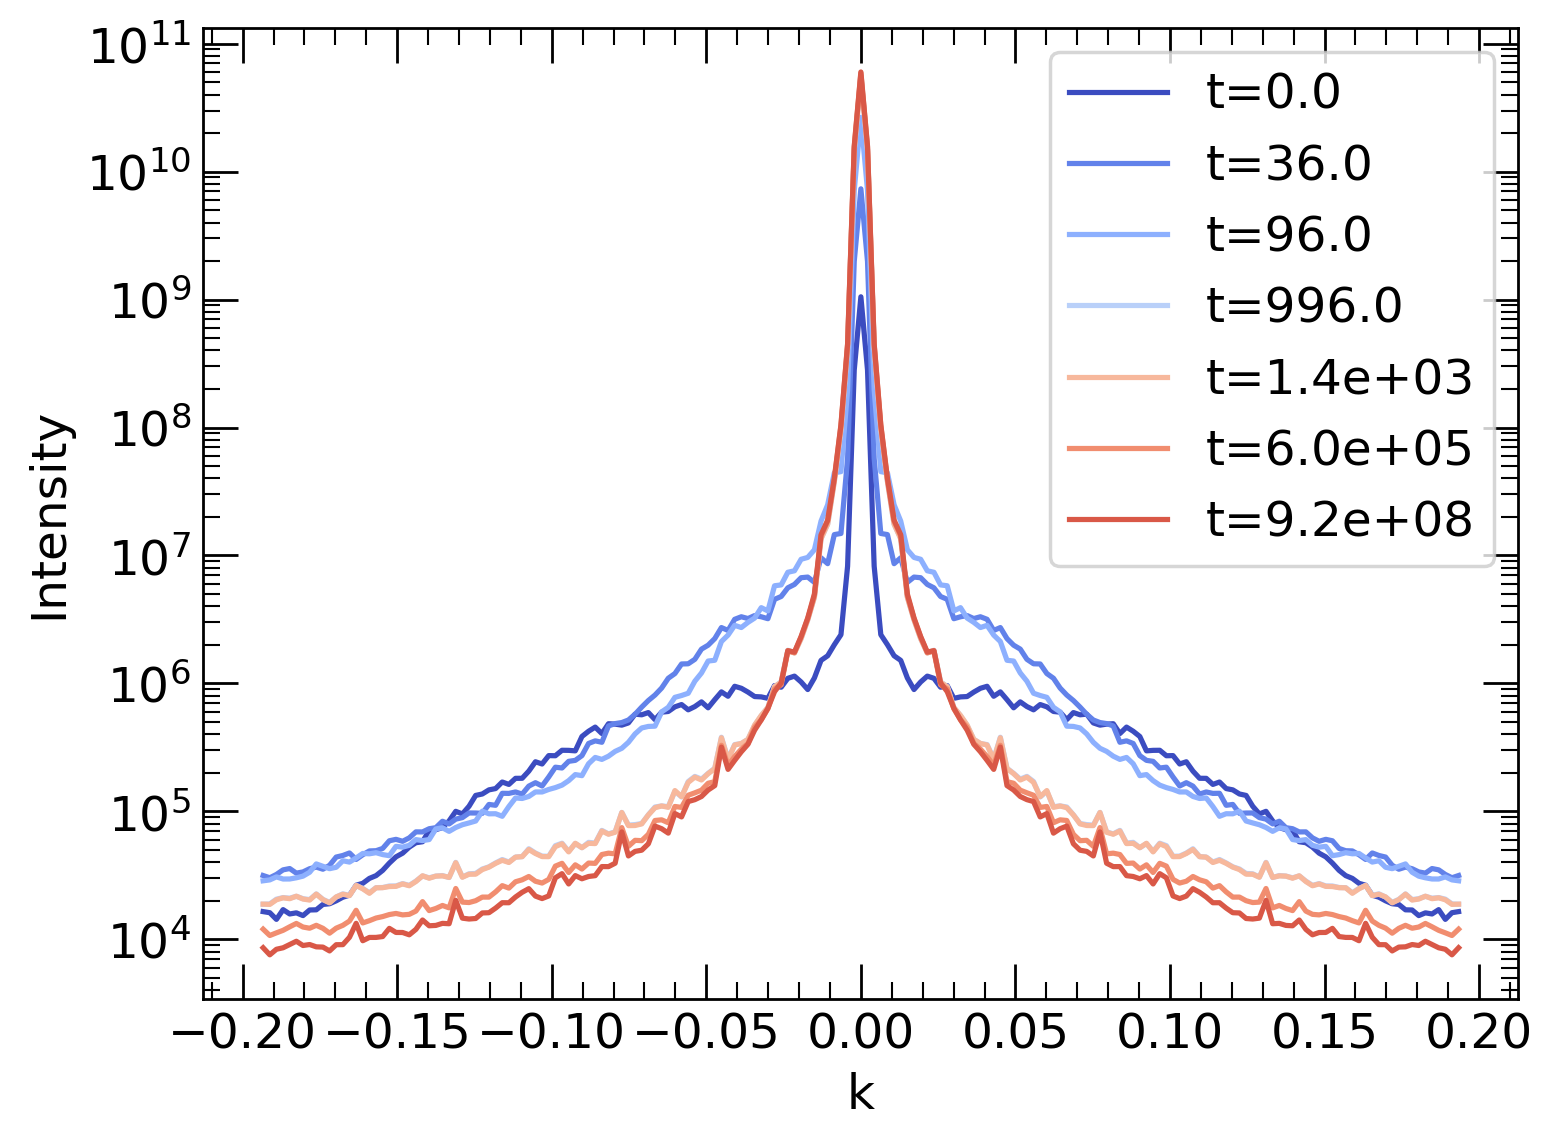

In [57]:
# t_inds=[0,5,12,76,102]
# t_inds=np.arange(0,40,8)
t_inds=[0,8,20,200]
full_tsteps=np.concatenate(([0],timeSteps))
norm = colors.Normalize(vmin=0, vmax=len(t_inds)*2)
cmap = cm.ScalarMappable(norm=norm, cmap=mpl.cm.coolwarm)
cmap.set_array([])

freqs=np.fft.fftshift(np.fft.fftfreq(padLen[0],1))
mov_avg_len=2.2
azi_lim=200
labels=full_tsteps[t_inds]
# labels=['0','81','221',r'$2.3\times 10^5$',r'$1.0\times 10^9$']
plt.figure()
for ind in tqdm(range(len(t_inds))):
    # b=freqs[251:]
    # data=np.convolve(np.ones(mov_avg_len,),xpcsStk[t_inds[ind]][250,251:],mode='same')
    # data=np.convolve(np.ones((10,)),np.concatenate(
    #         (xpcsStk[t_inds[ind]][250,:250],
    #          [np.nan],
    #          xpcsStk[t_inds[ind]][250,251:])),mode='same')
    b,data=azimuthal_average(xpcsStk[t_inds[ind]],binsize=mov_avg_len)
    data[0]=np.max(xpcsStk[t_inds[ind]])
    neg_side=np.argsort(-1*b)
    xs=np.concatenate((-1*b[neg_side[:-1]],b))
    ys=np.concatenate((data[neg_side[:-1]],data))
    use_mask=np.logical_and(np.abs(xs)<azi_lim,ys>0)
    plt.semilogy(xs[use_mask]/len(freqs),ys[use_mask],
        label='t='+str(labels[ind]),color=cmap.to_rgba(ind))

t_inds2=[220,310,401]
norm = colors.Normalize(vmin=-len(t_inds2)*2, vmax=len(t_inds2))
cmap = cm.ScalarMappable(norm=norm, cmap=mpl.cm.coolwarm)
cmap.set_array([])

freqs=np.fft.fftshift(np.fft.fftfreq(padLen[0],1))
labels=[f'{full_tsteps[t_inds2[k]]:.1e}' for k in range(len(t_inds2))]
for ind in tqdm(range(len(t_inds2))):
    # b=freqs[251:]
    # data=np.convolve(np.ones(mov_avg_len,),xpcsStk[t_inds[ind]][250,251:],mode='same')
    # data=np.convolve(np.ones((10,)),np.concatenate(
    #         (xpcsStk[t_inds[ind]][250,:250],
    #          [np.nan],
    #          xpcsStk[t_inds[ind]][250,251:])),mode='same')
    b,data=azimuthal_average(xpcsStk[t_inds2[ind]],binsize=mov_avg_len)
    data[0]=np.max(xpcsStk[t_inds2[ind]])
    neg_side=np.argsort(-1*b)
    xs=np.concatenate((-1*b[neg_side[:-1]],b))
    ys=np.concatenate((data[neg_side[:-1]],data))
    use_mask=np.logical_and(np.abs(xs)<azi_lim,ys>0)
    plt.semilogy(xs[use_mask]/len(freqs),ys[use_mask],
        label='t='+str(labels[ind]),color=cmap.to_rgba(ind))
plt.xlabel('k')
plt.ylabel('Intensity')
plt.legend(bbox_to_anchor=(1,1))
plt.tight_layout()
# plt.savefig(os.path.join(
#     'cell auto results/log-time-early-test/include-growth/scaled-t/starting-config-comp',
#     'pos-half-no-zero_linout_mov-avg{}.svg'.format(mov_avg_len)))
plt.savefig(os.path.join(
    'cell auto results',
    f'single-longtail_azimuth-{azi_lim}-lim_avg{mov_avg_len}.svg'))

In [180]:
neg_side=np.argsort(-1*b)
# print(np.concatenate((-1*b[neg_side[:-1]],b)))
print(neg_side)

[353 352 351 350 349 348 347 346 345 344 343 342 341 340 339 338 337 336
 335 334 333 332 331 330 329 328 327 326 325 324 323 322 321 320 319 318
 317 316 315 314 313 312 311 310 309 308 307 306 305 304 303 302 301 300
 299 298 297 296 295 294 293 292 291 290 289 288 287 286 285 284 283 282
 281 280 279 278 277 276 275 274 273 272 271 270 269 268 267 266 265 264
 263 262 261 260 259 258 257 256 255 254 253 252 251 250 249 248 247 246
 245 244 243 242 241 240 239 238 237 236 235 234 233 232 231 230 229 228
 227 226 225 224 223 222 221 220 219 218 217 216 215 214 213 212 211 210
 209 208 207 206 205 204 203 202 201 200 199 198 197 196 195 194 193 192
 191 190 189 188 187 186 185 184 183 182 181 180 179 178 177 176 175 174
 173 172 171 170 169 168 167 166 165 164 163 162 161 160 159 158 157 156
 155 154 153 152 151 150 149 148 147 146 145 144 143 142 141 140 139 138
 137 136 135 134 133 132 131 130 129 128 127 126 125 124 123 122 121 120
 119 118 117 116 115 114 113 112 111 110 109 108 10

In [23]:
t_inds=[0,5,12,76,102]
freqs=np.fft.fftshift(np.fft.fftfreq(padLen[0],1))
full_tsteps=np.concatenate(([0],timeSteps))
mov_avg_len=5
azi_lim=250
labels=['0','81','221',r'$2.3\times 10^5$',r'$1.0\times 10^9$']
plt.figure()
for ind in range(len(t_inds)):
    # b=freqs[251:]
    # data=np.convolve(np.ones(mov_avg_len,),xpcsStk[t_inds[ind]][250,251:],mode='same')
    # data=np.convolve(np.ones((10,)),np.concatenate(
    #         (xpcsStk[t_inds[ind]][250,:250],
    #          [np.nan],
    #          xpcsStk[t_inds[ind]][250,251:])),mode='same')
    # b,data=azimuthal_average(xpcsStk[t_inds[ind]],binsize=mov_avg_len)
    plt.semilogy(b[np.logical_and(b>-1,b<azi_lim)]/len(freqs),data[np.logical_and(b>-1,b<azi_lim)],
        label='t='+labels[ind])
plt.xlabel('k')
plt.ylabel('Intensity')
plt.legend()
# plt.savefig(os.path.join(
#     'cell auto results/log-time-early-test/include-growth/scaled-t/starting-config-comp',
#     'pos-half-no-zero_linout_mov-avg{}.svg'.format(mov_avg_len)))
# plt.savefig(os.path.join(
#     'cell auto results/log-time-early-test/include-growth/scaled-t/starting-config-comp',
#     'azimuth-{}-lim_avg{}.svg'.format(azi_lim,mov_avg_len)))

103

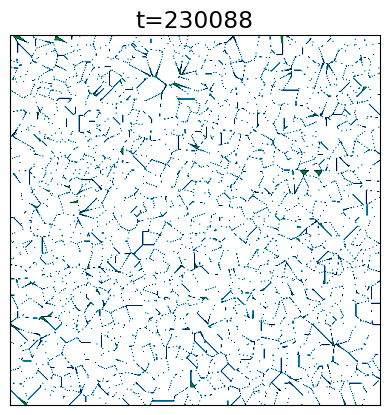

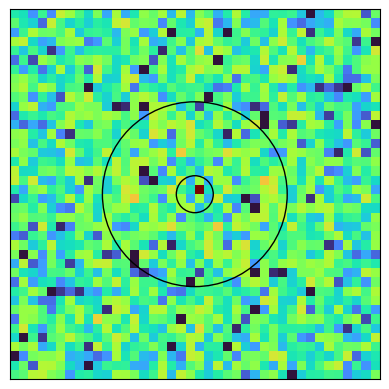

In [86]:
t=nSteps_growth+25
fig = plt.figure()
ax = plt.axes()
im = ax.imshow(imgStk[t],cmap='ocean',origin='lower')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
if t>0:
    ax.set_title('t={:n}'.format(timeSteps[t-1]))
    plt.savefig(os.path.join(foldername,'alpha{}-tau{}_real-space-t{:n}.png'.format(anneal_alpha,anneal_tau,timeSteps[t-1])))
else:
    ax.set_title('t=0')
    plt.savefig(os.path.join(foldername,'alpha{}-tau{}_real-space-t{:n}.png'.format(anneal_alpha,anneal_tau,0)))

fig = plt.figure()
ax = plt.axes()
im = ax.imshow(xpcsStk[t,nSize//2-50:nSize//2+50,nSize//2-50:nSize//2+50],norm=LogNorm(vmin=1e2,vmax=1e10),
               cmap='turbo',origin='lower',
               extent=[nSize//2-20,nSize//2+20,nSize//2-20,nSize//2+20])
# ax.add_patch(plt.Circle((nSize//2,nSize//2),radius=ROI_min,edgecolor='k',fill=False))
# ax.add_patch(plt.Circle((nSize//2,nSize//2),radius=ROI_max,edgecolor='k',fill=False))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
# plt.colorbar(im)
if t>0:
    plt.savefig(os.path.join(foldername,'alpha{}-tau{}_q-space-t{:n}.png'.format(anneal_alpha,anneal_tau,timeSteps[t-1])))
else:
    plt.savefig(os.path.join(foldername,'alpha{}-tau{}_q-space-t{:n}.png'.format(anneal_alpha,anneal_tau,0)))

In [ ]:
displayImg(xpcsStk[-1],colorScale='log',vmin=1e3,vmax=1e6)
displayImg(imgStk[-1],vmin=0,vmax=1)

In [ ]:
print(imgStk.shape)
plt.figure()
displayLine(np.arange(imgStk.shape[0]),nSize**2-np.sum(imgStk,axis=(1,2)),xyScale='loglog')

In [ ]:
edges=filters.sobel(imgStk,axis=(1,2))

In [ ]:
edges=np.zeros_like(imgStk)
for ind in range(edges.shape[0]):
    edges[ind]=filters.farid(imgStk[ind])

In [ ]:
displayImg(edges[-1])

In [ ]:
plt.figure()
plt.plot(np.sum(edges,axis=(1,2))/np.max(np.sum(edges,axis=(1,2))))
plt.plot(np.sum(xpcsStk,axis=(1,2))/np.sum(xpcsStk[-1]))

animation block

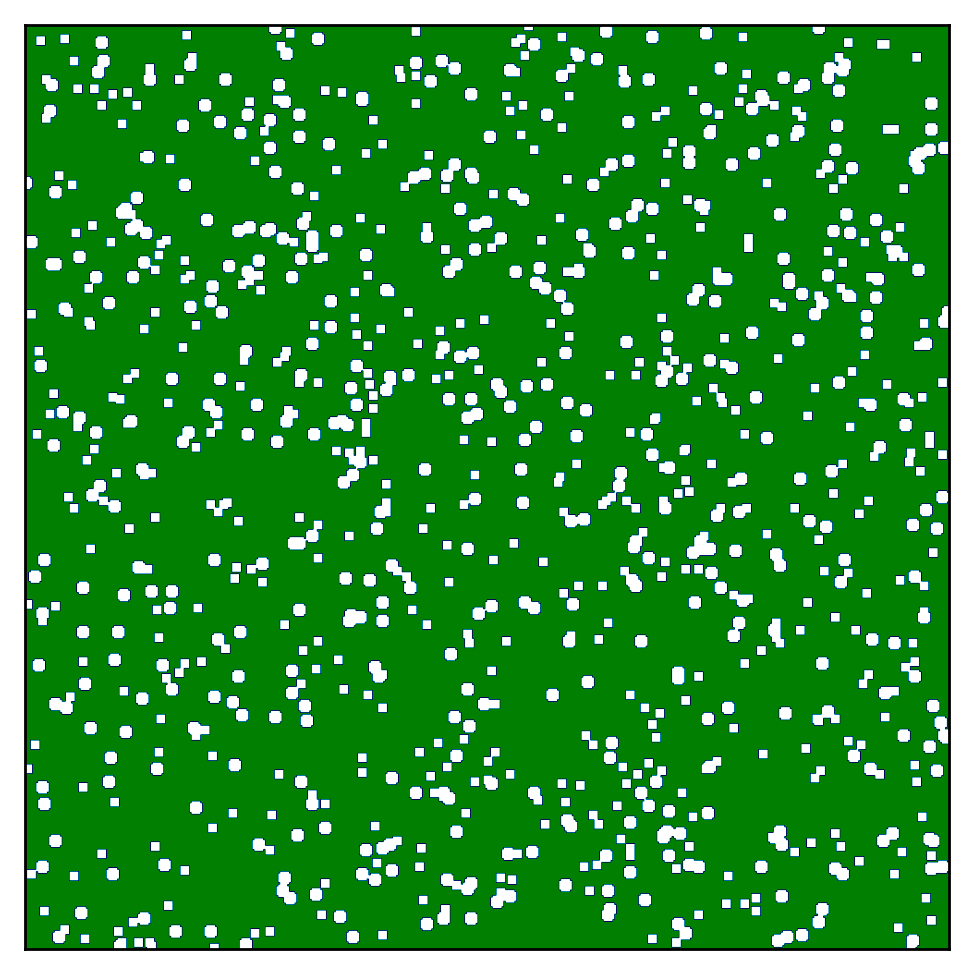

In [25]:
fig = plt.figure()
ax = plt.axes()
im = ax.imshow(imgStk[0],cmap='ocean',origin='lower')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
def init():
    im.set_data(imgStk[0])
    return [im]

def animate(i):
    ind=i%imgStk.shape[0]
#     print(ind)
    im.set_data(imgStk[ind])
    return [im]

anim=animation.FuncAnimation(fig,animate,init_func=init,frames=nSteps_growth+nSteps_anneal)
anim.save(os.path.join(foldername,'nuclei_anim_bound-alpha-{:.2f}-tau{:.2E}-bound{}-{}.gif'.format(anneal_alpha,anneal_tau,boundary_thres_start,boundary_thres_final)),writer=animation.PillowWriter(fps=(nSteps_growth+nSteps_anneal)/25))

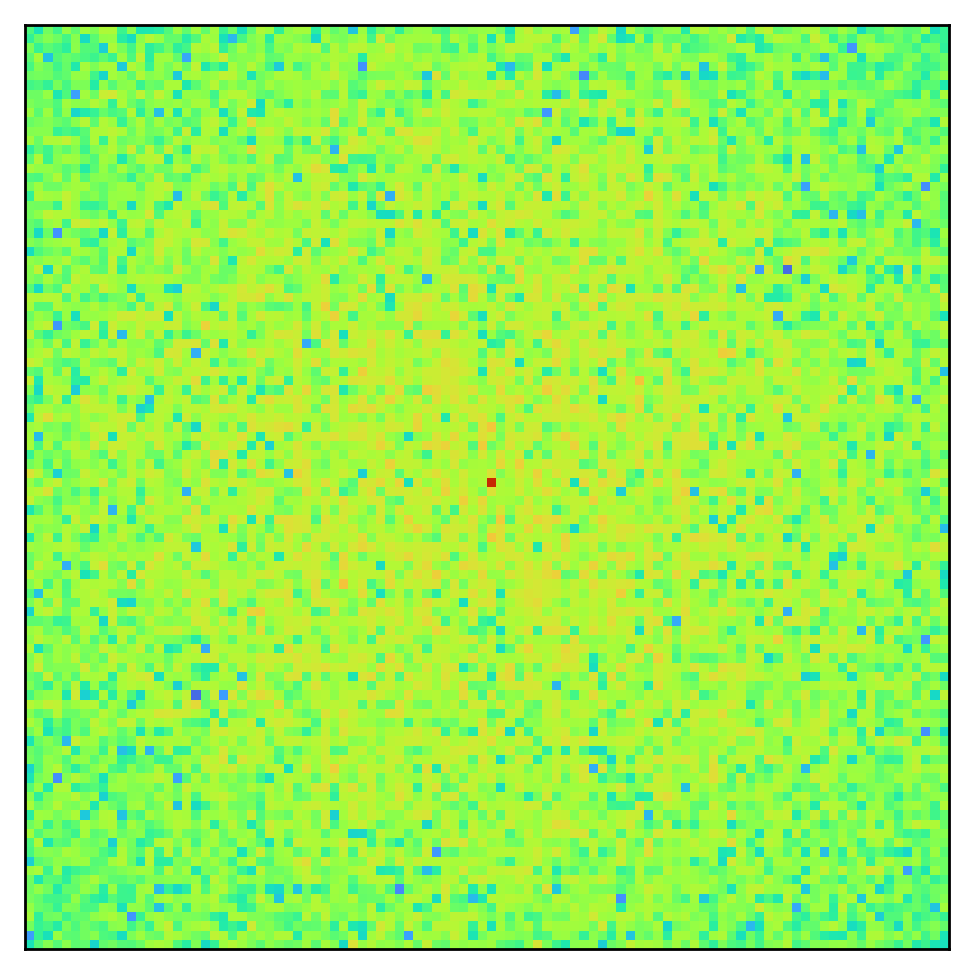

In [29]:
width=50
ROI_min=2
ROI_max=10
fig = plt.figure()
ax = plt.axes()
im = ax.imshow(xpcsStk[0,nSize//2-width:nSize//2+width,nSize//2-width:nSize//2+width],norm=LogNorm(vmin=10,vmax=1e10),
               cmap='turbo',origin='lower',
               extent=[nSize//2-width,nSize//2+width,nSize//2-width,nSize//2+width])
# ax.add_patch(plt.Circle((nSize//2,nSize//2),radius=ROI_min,edgecolor='k',fill=False))
# ax.add_patch(plt.Circle((nSize//2,nSize//2),radius=ROI_max,edgecolor='k',fill=False))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
def init():
    im.set_data(xpcsStk[0,nSize//2-width:nSize//2+width,nSize//2-width:nSize//2+width])
    return [im]

def animate(i):
    ind=i%xpcsStk.shape[0]
#     print(ind)
    im.set_data(xpcsStk[ind,nSize//2-width:nSize//2+width,nSize//2-width:nSize//2+width])
    return [im]

anim=animation.FuncAnimation(fig,animate,init_func=init,frames=nSteps_growth+nSteps_anneal)
anim.save(os.path.join(foldername,'xpcsStk_bound-alpha-{:.2f}-tau{:.2E}-bound{}-{}_rad{}.gif'.format(anneal_alpha,anneal_tau,boundary_thres_start,boundary_thres_final,width)),writer=animation.PillowWriter(fps=(nSteps_growth+nSteps_anneal)/25))

smoothing cell

In [ ]:
kernel=sg2d(3,5,5)
smoothed=np.zeros_like(xpcsStk)
for step in range(xpcsStk.shape[0]):
    smoothed[step,:,:]=ndimage.convolve(xpcsStk[step,:,:],kernel)


In [ ]:
smoothed_waterfall=genCirROI(smoothed,ROI_min,ROI_max)

In [121]:
ROI_min=2
ROI_max=10

In [123]:
waterfall = genCirROI(xpcsStk,ROI_min, ROI_max)
# ROI=[50,150,50,150]
# waterfall=genBoxROI(xpcsStk,ROI=ROI)

crude normalize waterfall

In [ ]:
for ind in range(waterfall.shape[0]):
    waterfall[ind,:]=waterfall[ind,:]/xpcsStk[ind].max()

normalize by mean of row instead of maximum

In [69]:
for row in range(waterfall.shape[0]):
    waterfall[row,:]=waterfall[row,:]/np.mean(waterfall[row,:])

smooth normalize waterfall

In [ ]:
waterfall=waterfall/smoothed_waterfall

In [ ]:
plt.imshow(waterfall/smoothed_waterfall,origin='lower',cmap='jet')
plt.colorbar()

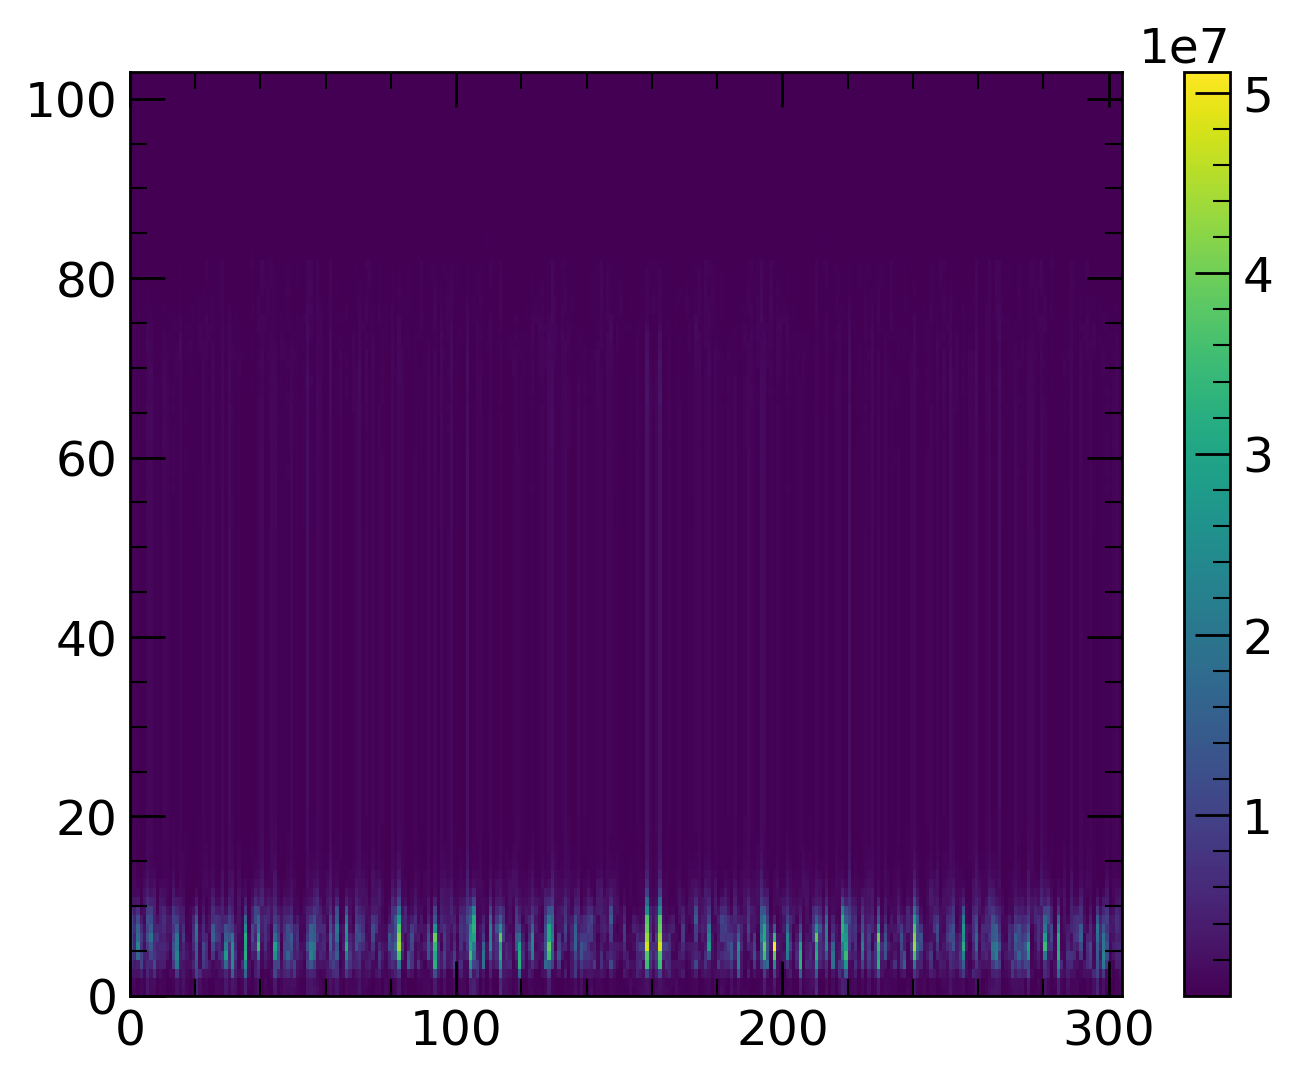

In [27]:
plt.pcolormesh(waterfall)
plt.colorbar()
# showROI(xpcsStk[0],[ROI],mode='pyplot')

In [125]:
tt1 = calcTwoTime(waterfall,'Sutton')

***** XPCS two-time processed in 0.24944257736206055 sec *****


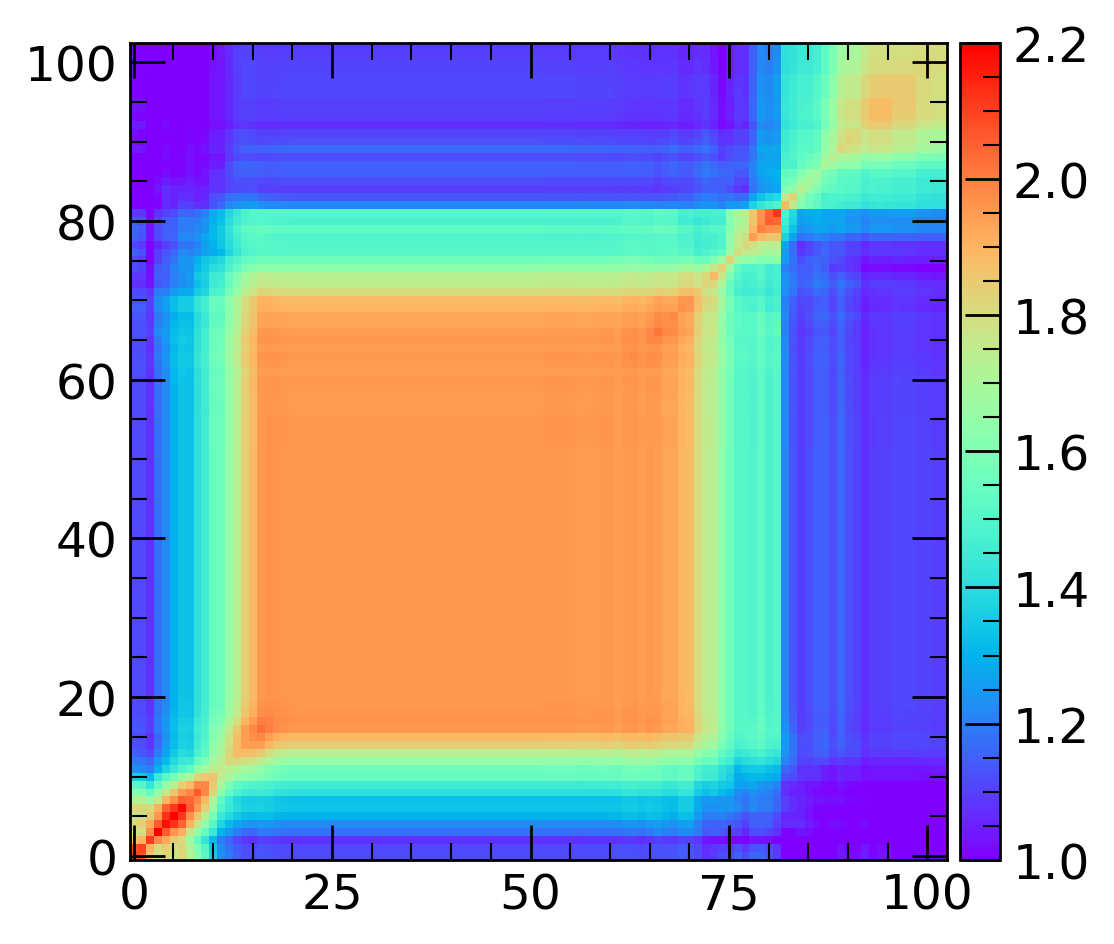

In [29]:
# plt.figure()
# plt.pcolormesh(np.concatenate(([0],timeSteps)),np.concatenate(([0],timeSteps)),tt1,vmin=1,vmax=2.2,cmap='rainbow')
# plt.xscale('log')
# plt.yscale('log')
# plt.colorbar()
plotTwoTime(tt1,vmin=1,vmax=2.2)
# plt.savefig(os.path.join(foldername,'TT_longtail_alpha{}_tau{}.svg'.format(anneal_alpha,anneal_tau)))

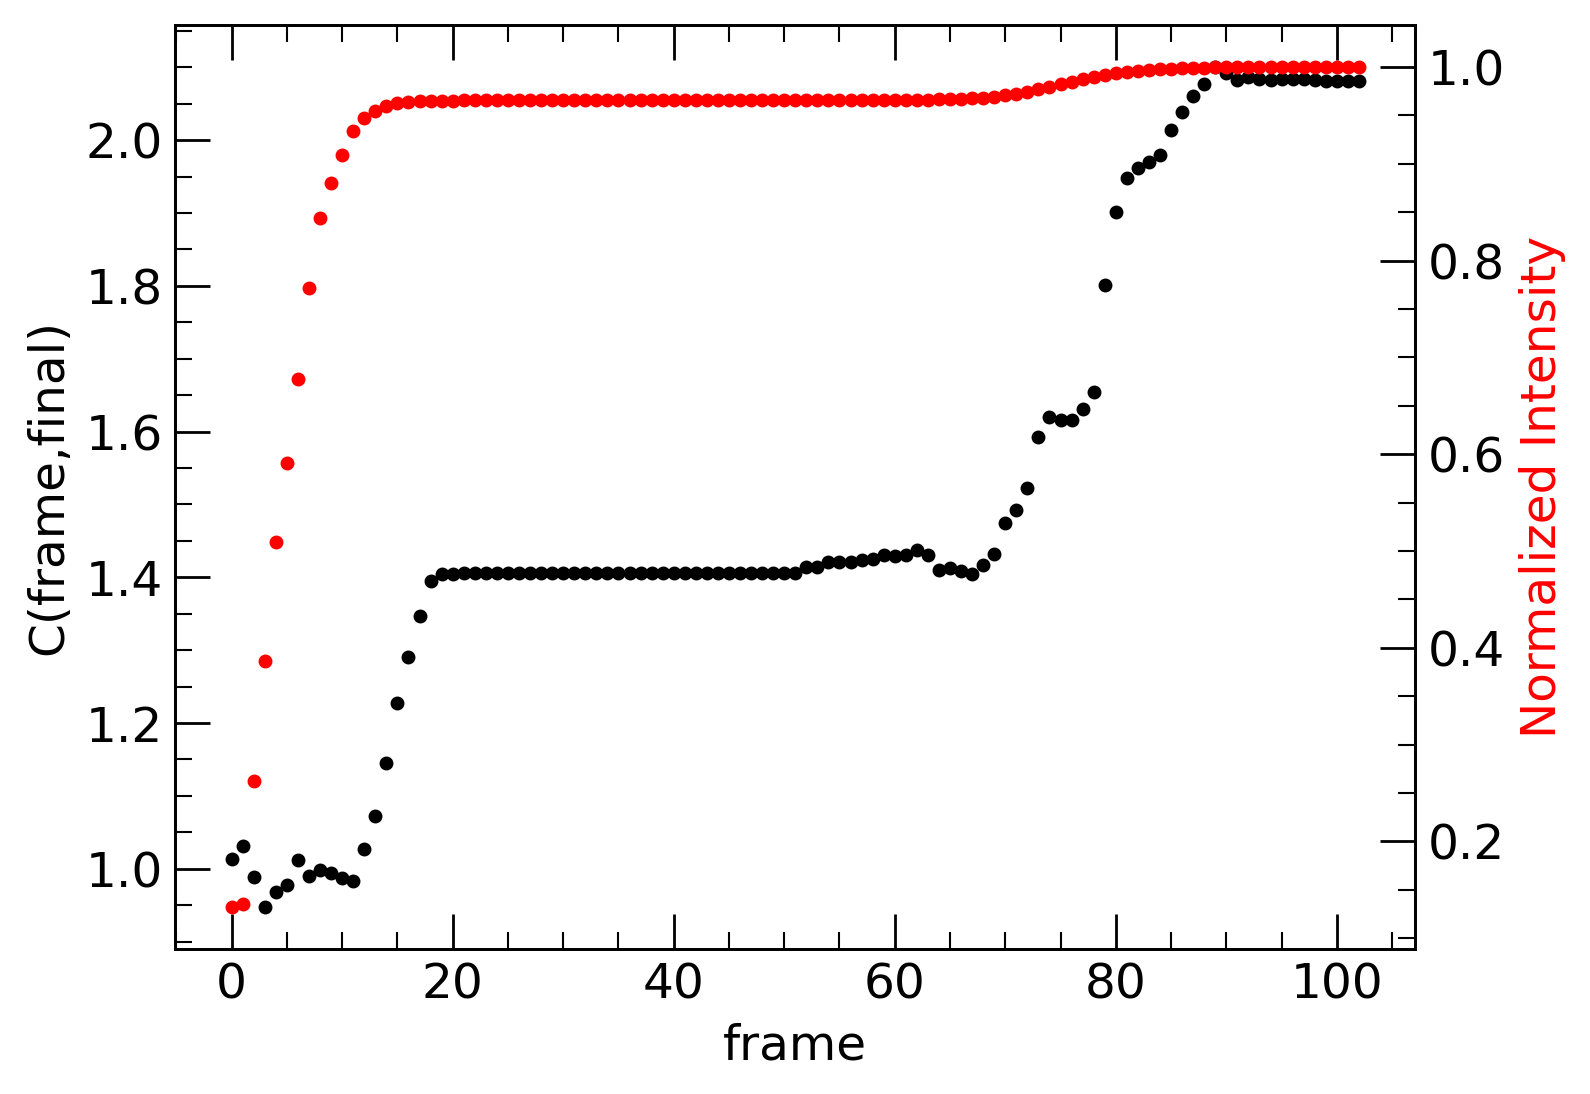

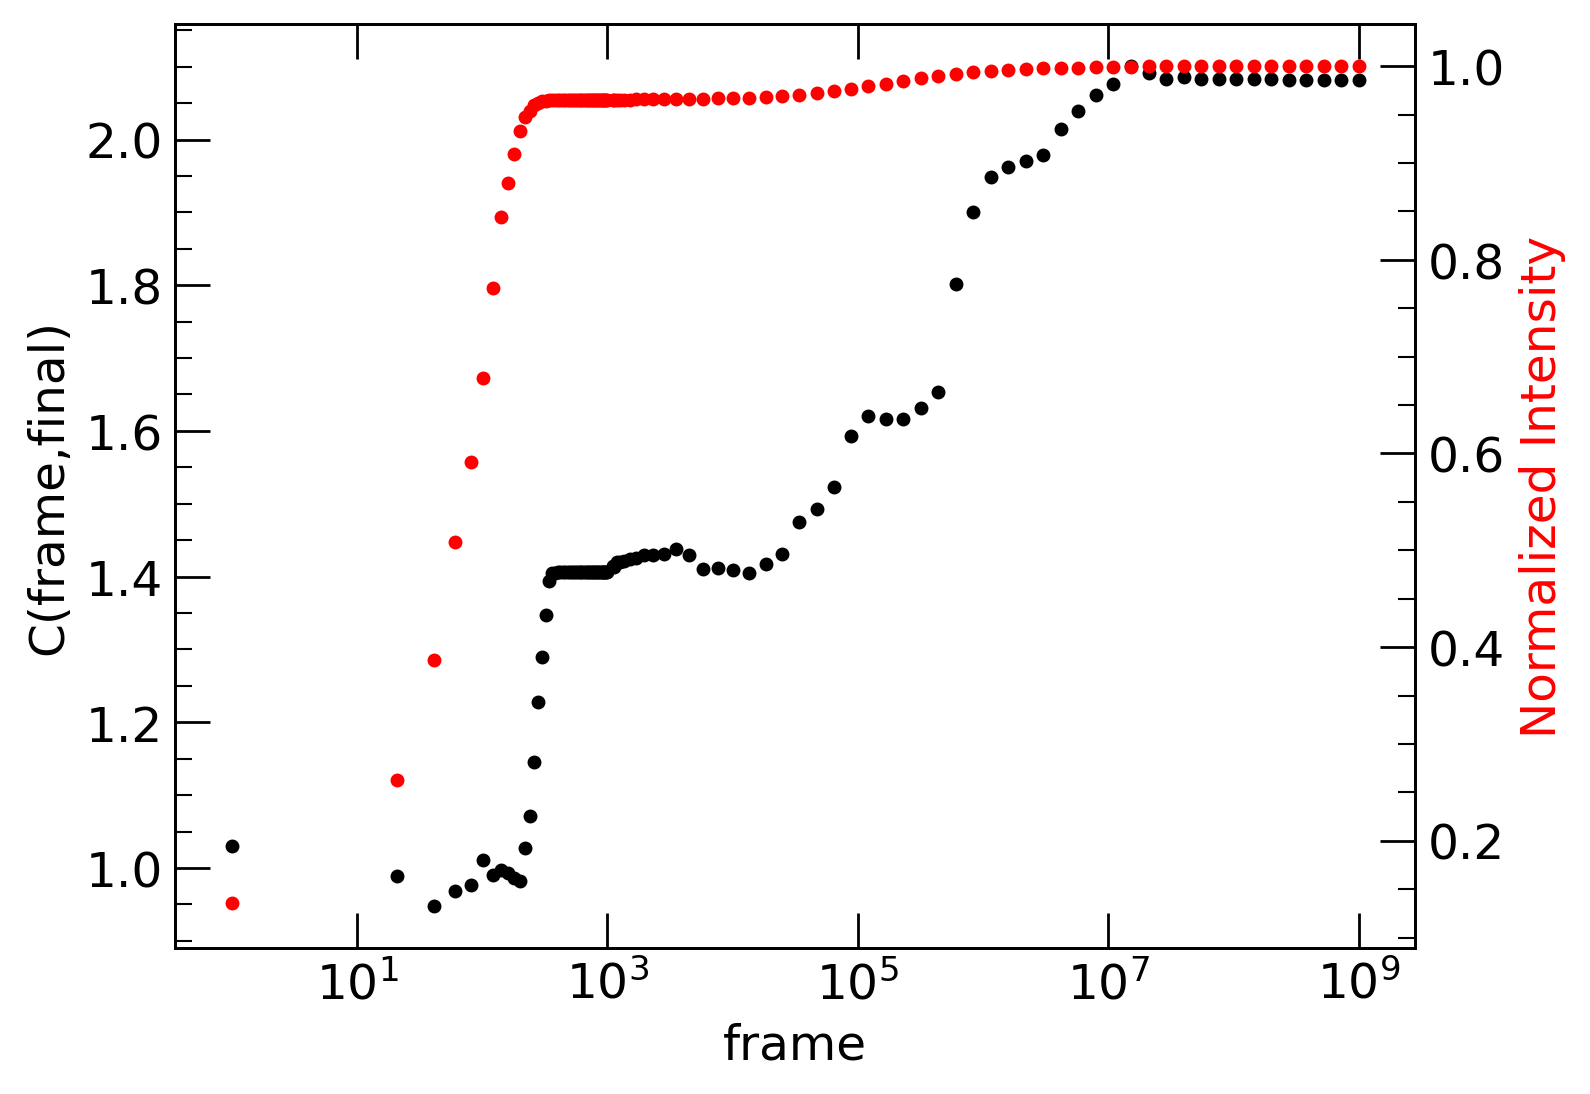

In [129]:
normed_sums=np.sum(xpcsStk,axis=(1,2))/np.sum(xpcsStk[-1])
fig, ax_left=plt.subplots()
ax_left.plot(tt1[-1,:],'k.')
ax_left.set_ylabel('C(frame,final)')
ax_left.set_xlabel('frame')
# ax_left.set_yscale('log')

ax_right = ax_left.twinx()
ax_right.plot(normed_sums,'r.')
ax_right.set_ylabel('Normalized Intensity')
ax_right.yaxis.label.set_color('r')

# plt.savefig(os.path.join(foldername,'corr_int_row-mean_lin-x-scale_start{}-final{}.svg'.format(boundary_thres_start,boundary_thres_final)))

fig, ax_left=plt.subplots()
ax_left.semilogx(np.concatenate(([0],timeSteps)),tt1[-1,:],'k.')
ax_left.set_ylabel('C(frame,final)')
ax_left.set_xlabel('frame')
# ax_left.set_yscale('log')

ax_right = ax_left.twinx()
ax_right.semilogx(np.concatenate(([0],timeSteps)),normed_sums,'r.')
ax_right.set_ylabel('Normalized Intensity')
ax_right.yaxis.label.set_color('r')
# plt.savefig(os.path.join(foldername,'corr_int_row-mean_log-x-scale_start{}-final{}.svg'.format(boundary_thres_start,boundary_thres_final)))

In [219]:
np.max(xpcsStk,axis=(1,2))

array([1.05118608e+09, 1.09819332e+09, 3.97164644e+09, 8.94405233e+09,
       1.45639038e+10, 2.09896349e+10, 2.67191716e+10, 3.27186597e+10,
       3.73826757e+10, 4.17993936e+10, 4.43692096e+10, 4.67675226e+10,
       4.82746812e+10, 4.92644659e+10, 4.97834269e+10, 5.01186724e+10,
       5.03181165e+10, 5.04797543e+10, 5.05791104e+10, 5.06178003e+10,
       5.06290501e+10, 5.06290501e+10, 5.06304001e+10, 5.06304001e+10,
       5.06304001e+10, 5.06304001e+10, 5.06304001e+10, 5.06304001e+10,
       5.06304001e+10, 5.06304001e+10, 5.06304001e+10, 5.06304001e+10,
       5.06304001e+10, 5.06304001e+10, 5.06304001e+10, 5.06304001e+10,
       5.06304001e+10, 5.06304001e+10, 5.06304001e+10, 5.06304001e+10,
       5.06304001e+10, 5.06304001e+10, 5.06304001e+10, 5.06304001e+10,
       5.06304001e+10, 5.06304001e+10, 5.06304001e+10, 5.06304001e+10,
       5.06304001e+10, 5.06304001e+10, 5.06304001e+10, 5.06304001e+10,
       5.06583055e+10, 5.06583055e+10, 5.06583055e+10, 5.06583055e+10,
      

In [18]:
displayLine(np.arange(1+nSteps_anneal+nSteps_growth),tt1[-1,:])
displayLine(timeSteps[-nSteps_anneal:],tt1[-1,-nSteps_anneal:],xyScale='semilogx')
displayLine(timeSteps[-nSteps_anneal:],percent_anneal_per_timestep,xyScale='semilogx')

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

In [ ]:
t_inds=[0,9,20,60,70,85,92]
titles=['beginning','before plateau','start of plateau','start of annealing','before second rise','mid second rise','end second rise']
full_tsteps=np.concatenate(([0],timeSteps))
# print(full_tsteps[t_inds])
prev_t=0
for ind in range(len(t_inds)):
    fig, ax = plt.subplots(1,3)
    ax[0].imshow(imgStk[t_inds[ind]],vmin=0,vmax=1,origin='lower',cmap='ocean')
    ax[0].set_xticks([])
    ax[0].set_yticks([])

    # ax.set_title('t={:n}'.format(full_tsteps[t_inds[ind]]))
    ax[0].set_title(titles[ind])

    ax[1].imshow(imgStk[t_inds[ind]]-imgStk[t_inds[prev_t]],origin='lower',vmin=0,vmax=1,cmap='binary')
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    
    ax[2].imshow(imgStk[-1]-imgStk[t_inds[ind]],origin='lower',vmin=0,vmax=1,cmap='binary')
    ax[2].set_xticks([])
    ax[2].set_yticks([])
    # plt.savefig(os.path.join(foldername,'alpha{}-tau{}_real-space-t{:.2e}.png'.format(anneal_alpha,anneal_tau,full_tsteps[t_inds[ind]])))
    prev_t=ind

prev_t=0
for ind in range(len(t_inds)):
    fig, ax = plt.subplots()
    ax.imshow(xpcsStk[t_inds[ind],nSize//2-20:nSize//2+20,nSize//2-20:nSize//2+20],
                   norm=LogNorm(vmin=1e3,vmax=1e8),
                   cmap='turbo',origin='lower',
                   extent=[nSize//2-20,nSize//2+20,nSize//2-20,nSize//2+20]
                  )
    ax.set_xticks([])
    ax.set_yticks([])
    # ax.set_title('t={:n}'.format(full_tsteps[t_inds[ind]]))
    ax.set_title(titles[ind])
    # plt.savefig(
    #     os.path.join(
    #         foldername,'alpha{}-tau{}_q-space-t{}.png'.format(anneal_alpha,anneal_tau,full_tsteps[t_inds[ind]])))

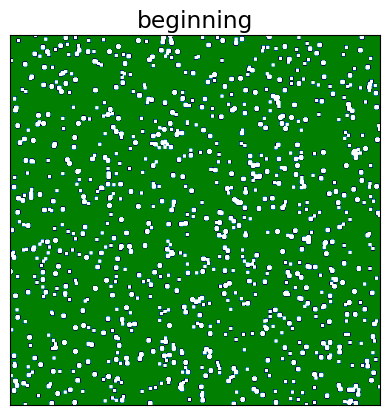

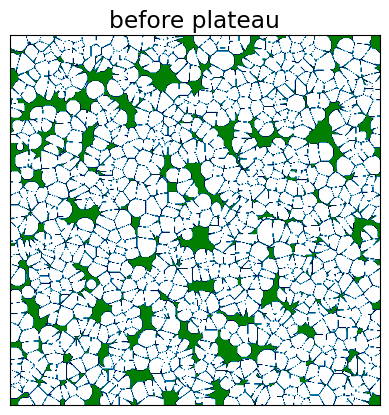

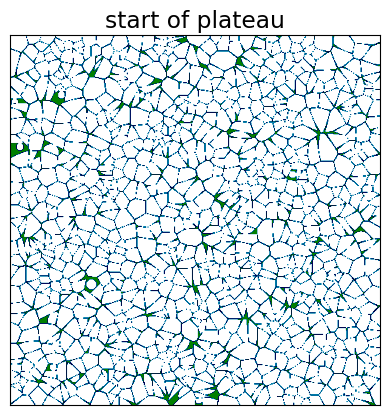

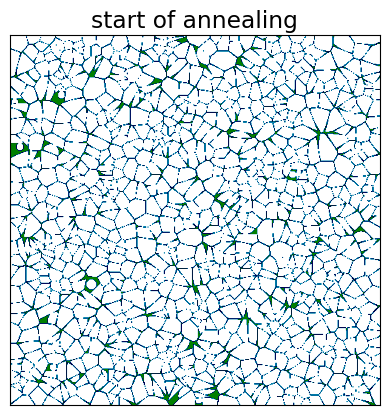

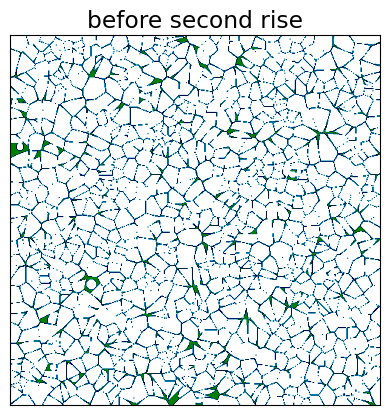

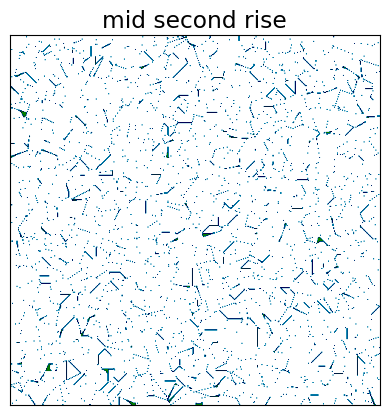

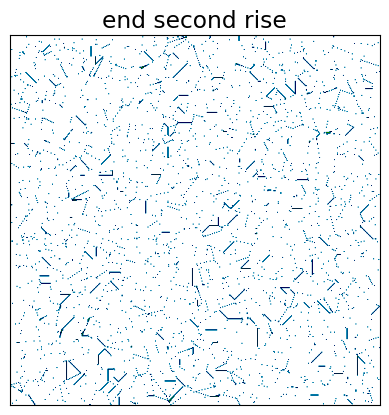

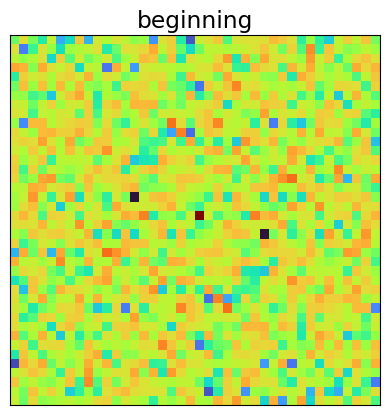

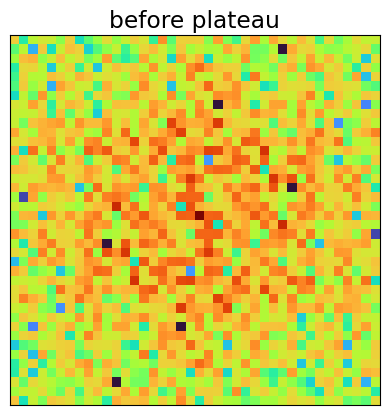

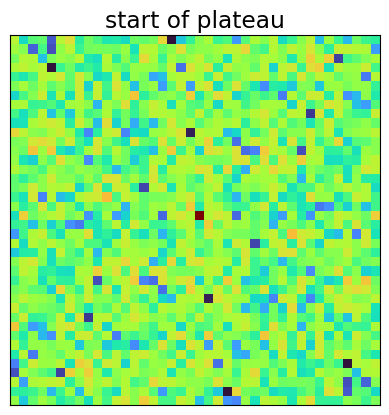

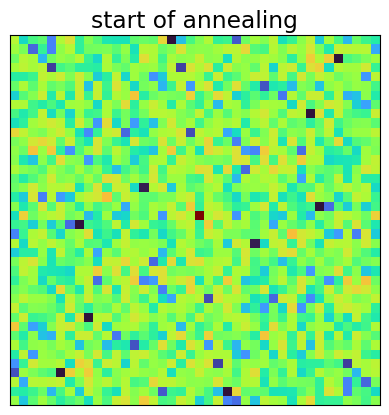

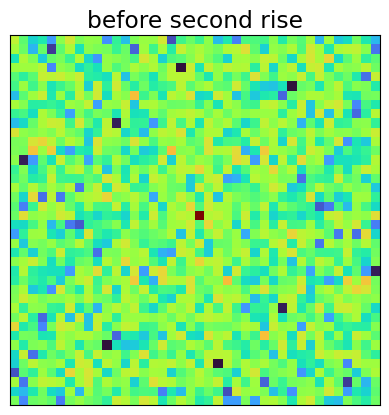

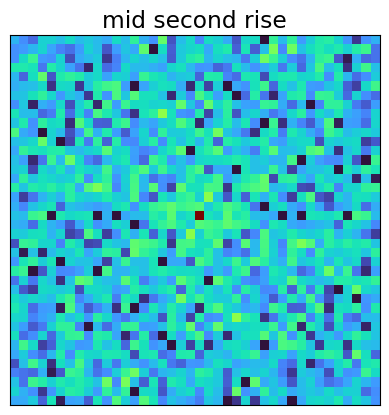

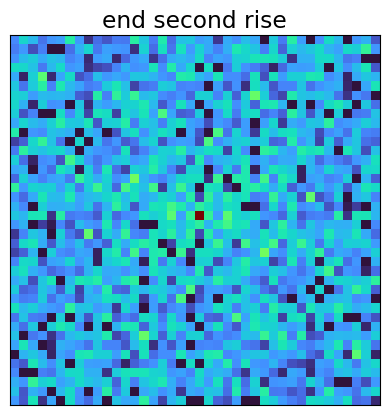

In [22]:
t_inds=[0,9,20,60,70,85,92]
titles=['beginning','before plateau','start of plateau','start of annealing','before second rise','mid second rise','end second rise']
full_tsteps=np.concatenate(([0],timeSteps))
# print(full_tsteps[t_inds])
prev_t=0
for ind in range(len(t_inds)):
    fig, ax = plt.subplots(1,1)
    ax.imshow(imgStk[t_inds[ind]],vmin=0,vmax=1,origin='lower',cmap='ocean')
    ax.set_xticks([])
    ax.set_yticks([])

    # ax.set_title('t={:n}'.format(full_tsteps[t_inds[ind]]))
    ax.set_title(titles[ind])
    plt.savefig(
        os.path.join(
            foldername,'alpha{}-tau{}_real-space-t{}.png'.format(
                anneal_alpha,anneal_tau,full_tsteps[t_inds[ind]])))
prev_t=0
for ind in range(len(t_inds)):
    fig, ax = plt.subplots()
    ax.imshow(xpcsStk[t_inds[ind],nSize//2-20:nSize//2+20,nSize//2-20:nSize//2+20],
                   norm=LogNorm(vmin=1e3,vmax=1e8),
                   cmap='turbo',origin='lower',
                   extent=[nSize//2-20,nSize//2+20,nSize//2-20,nSize//2+20]
                  )
    ax.set_xticks([])
    ax.set_yticks([])
    # ax.set_title('t={:n}'.format(full_tsteps[t_inds[ind]]))
    ax.set_title(titles[ind])
    plt.savefig(
        os.path.join(
            foldername,'alpha{}-tau{}_q-space-t{}.png'.format(
                anneal_alpha,anneal_tau,full_tsteps[t_inds[ind]])))

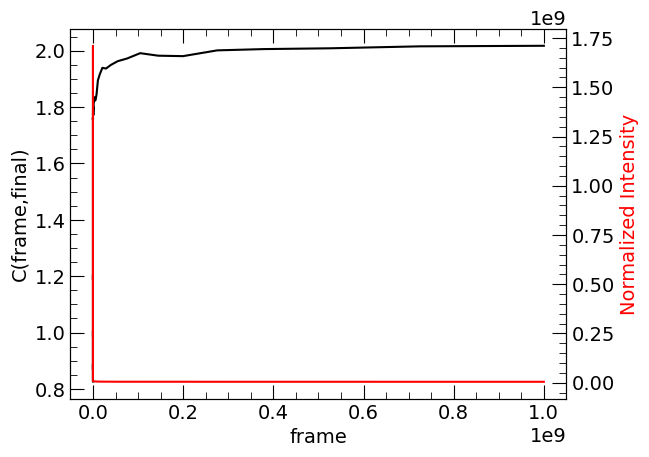

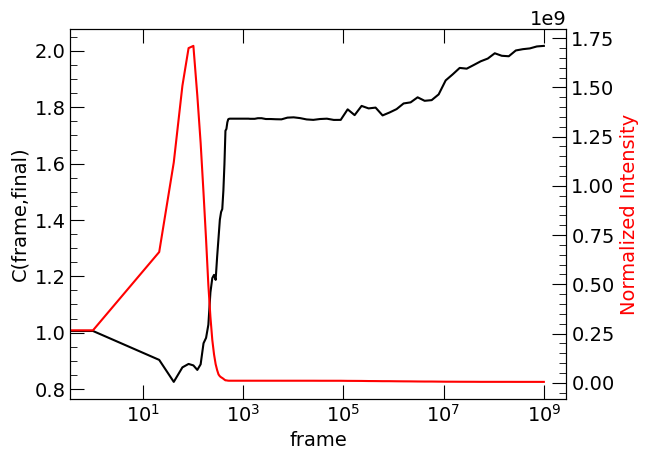

In [99]:
normed_sums=np.sum(waterfall,axis=1)
fig, ax_left=plt.subplots()
ax_left.plot(np.concatenate(([0],timeSteps)),tt1[-1,:],'k')
ax_left.set_ylabel('C(frame,final)')
ax_left.set_xlabel('frame')
# ax_left.set_yscale('log')

ax_right = ax_left.twinx()
ax_right.plot(np.concatenate(([0],timeSteps)),normed_sums,'r')
ax_right.set_ylabel('Normalized Intensity')
ax_right.yaxis.label.set_color('r')

# plt.savefig(os.path.join(foldername,'corr_int_row-mean_lin-x-scale_start{}-final{}.svg'.format(boundary_thres_start,boundary_thres_final)))

fig, ax_left=plt.subplots()
ax_left.semilogx(np.concatenate(([0],timeSteps)),tt1[-1,:],'k')
ax_left.set_ylabel('C(frame,final)')
ax_left.set_xlabel('frame')
# ax_left.set_yscale('log')

ax_right = ax_left.twinx()
ax_right.semilogx(np.concatenate(([0],timeSteps)),normed_sums,'r')
ax_right.set_ylabel('Normalized Intensity')
ax_right.yaxis.label.set_color('r')
# plt.savefig(os.path.join(foldername,'corr_int_row-mean_log-x-scale_start{}-final{}.svg'.format(boundary_thres_start,boundary_thres_final)))

In [16]:
boundaries_start=pixel_boundary_ratios<boundary_thres_start
boundaries_final=pixel_boundary_ratios<boundary_thres_final

total_area_start=np.sum(np.logical_not(boundaries_start))
average_nucleus_area_start=total_area_start/nCen
average_nucleus_half_square_side_start=np.sqrt(average_nucleus_area_start)/2
average_nucleus_rad_start=np.sqrt(average_nucleus_area_start/np.pi)
print(average_nucleus_half_square_side_start,average_nucleus_rad_start)

total_area_final=np.sum(np.logical_not(boundaries_final))
average_nucleus_area_final=total_area_final/nCen
average_nucleus_half_square_side_final=np.sqrt(average_nucleus_area_final)/2
average_nucleus_rad_final=np.sqrt(average_nucleus_area_final/np.pi)
print(average_nucleus_half_square_side_final,average_nucleus_rad_final)

7.5050316455029025 8.46852135717803
7.829096371868212 8.834189243199152


In [ ]:
ds=np.linspace(0,10,nSize)
qs=np.fft.fftshift(np.fft.fftfreq(nSize,(ds[1]-ds[0])))*2*np.pi
ROI_min_q=(qs[1]-qs[0])*ROI_min
ROI_max_q=(qs[1]-qs[0])*ROI_max
print('0 progress')
fig=plt.figure(figsize=(2,2))
# plt.pcolormesh(ds,ds,imgStk[0],cmap='ocean')
plt.imshow(imgStk[0],cmap='ocean',origin='lower')
# plt.xlabel(r'x')
# plt.ylabel(r'y')
plt.tick_params('both',which='both',direction='out',top=False,right=False,bottom=False,left=False)
plt.xticks([])
plt.yticks([])
# plt.xticks([0,10])
# plt.yticks([0,10])
# plt.tight_layout(pad=0.4)
plt.savefig('cell auto results/30nucs_300size_200steps_1rate-markov_with-hard-boundaries_bound-reduc/real-space-0_unlabeled.svg')

print('1/6 progress')
plt.figure(figsize=(2,2))
# ax.pcolormesh(ds,ds,imgStk[100],cmap='ocean')
plt.imshow(imgStk[100],cmap='ocean',origin='lower')
# ax.set_xlabel(r'x')
# ax.set_ylabel(r'y')
plt.tick_params('both',which='both',direction='out',top=False,right=False,left=False,bottom=False)
plt.xticks([])
plt.yticks([])
# plt.xticks([0,10])
# plt.yticks([0,10])
# plt.tight_layout(pad=0.4)
plt.savefig('cell auto results/30nucs_300size_200steps_1rate-markov_with-hard-boundaries_bound-reduc/real-space-100_unlabeled.svg')

print('2/6 progress')
fig, ax=plt.subplots(figsize=(2,2))
# ax.pcolormesh(ds,ds,imgStk[-1],cmap='ocean')
ax.imshow(imgStk[-1],cmap='ocean',origin='lower')
ax.tick_params('both',which='both',direction='out',top=False,right=False,left=False,bottom=False)
plt.xticks([])
plt.yticks([])
# ax.set_xlabel(r'x')
# ax.set_ylabel(r'y')
# plt.xticks([0,10])
# plt.yticks([0,10])
# plt.tight_layout(pad=0.4)
plt.savefig('cell auto results/30nucs_300size_200steps_1rate-markov_with-hard-boundaries_bound-reduc/real-space-200_unlabeled.svg')

print('3/6 progress')
fig, ax=plt.subplots(figsize=(2,2))
ax.pcolormesh(qs[70:231],qs[70:231],xpcsStk[0,70:231,70:231],norm=LogNorm(vmin=1e0,vmax=1e10),cmap='turbo')
# ax.imshow(xpcsStk[0,70:231,70:231],norm=LogNorm(vmin=1e0,vmax=1e10),cmap='turbo',origin='lower')
ax.tick_params('both',which='both',direction='out',top=False,right=False,left=False,bottom=False)
plt.xticks([])
plt.yticks([])
# ax.tick_params('both',which='minor',bottom=False,left=False)
# ax.tick_params('both',which='major',length=3)
# ax.set_xlabel(r'$q_{x}$')
# ax.set_ylabel(r'$q_{y}$')
# plt.tight_layout(pad=0.2)
ax.add_patch(plt.Circle((0,0),radius=ROI_min_q,edgecolor='k',fill=False))
ax.add_patch(plt.Circle((0,0),radius=ROI_max_q,edgecolor='k',fill=False))
plt.savefig('cell auto results/30nucs_300size_200steps_1rate-markov_with-hard-boundaries_bound-reduc/recip-space-0_unlabeled.svg')

print('4/6 progress')
fig, ax=plt.subplots(figsize=(2,2))
ax.pcolormesh(qs[70:231],qs[70:231],xpcsStk[100,70:231,70:231],norm=LogNorm(vmin=1e0,vmax=1e10),cmap='turbo')
# ax.imshow(xpcsStk[100,70:231,70:231],norm=LogNorm(vmin=1e0,vmax=1e10),cmap='turbo',origin='lower')
ax.tick_params('both',which='both',direction='out',top=False,right=False,left=False,bottom=False)
plt.xticks([])
plt.yticks([])
# ax.tick_params('both',which='minor',bottom=False,left=False)
# ax.tick_params('both',which='major',length=3)
# ax.set_xlabel(r'$q_{x}$')
# ax.set_ylabel(r'$q_{y}$')
# plt.tight_layout(pad=0.2)
ax.add_patch(plt.Circle((0,0),radius=ROI_min_q,edgecolor='k',fill=False))
ax.add_patch(plt.Circle((0,0),radius=ROI_max_q,edgecolor='k',fill=False))
# ax.annotate(r'$10^{3}$',(1.1e-2,-1.1e-2))
plt.savefig('cell auto results/30nucs_300size_200steps_1rate-markov_with-hard-boundaries_bound-reduc/recip-space-100_unlabeled.svg')

print('5/6 progress')
fig, ax=plt.subplots(figsize=(2,2))
ax.pcolormesh(qs[70:231],qs[70:231],xpcsStk[-1,70:231,70:231],norm=LogNorm(vmin=1e0,vmax=1e10),cmap='turbo')
# ax.imshow(xpcsStk[-1,70:231,70:231],norm=LogNorm(vmin=1e0,vmax=1e10),cmap='turbo',origin='lower')
ax.tick_params('both',which='both',direction='out',top=False,right=False,left=False,bottom=False)
plt.xticks([])
plt.yticks([])
# ax.tick_params('both',which='minor',bottom=False,left=False)
# ax.tick_params('both',which='major',length=3)
# ax.set_xlabel(r'$q_{x}$')
# ax.set_ylabel(r'$q_{y}$')
# plt.tight_layout(pad=0.2)
ax.add_patch(plt.Circle((0,0),radius=ROI_min_q,edgecolor='k',fill=False))
ax.add_patch(plt.Circle((0,0),radius=ROI_max_q,edgecolor='k',fill=False))
plt.savefig('cell auto results/30nucs_300size_200steps_1rate-markov_with-hard-boundaries_bound-reduc/recip-space-200_unlabeled.svg')
print('6/6 progress')

# plt.savefig('nucleation and growth trip.svg')

In [ ]:
g2,_=calcG2(tt1)
plt.plot(g2)

In [ ]:
(nSize**2-np.sum(imgStk[int(boundary_thres_start)]))/(nSize**2-np.sum(imgStk[-1]))

## New nucleation center only

In [ ]:
# Defining the parameters
nCen = 40 # Number of nucleus
nSize = 200 # Field of view
nSteps = 300 # Steps
nChange = 4 # Number of nucleus changed
iniR = 2 # Initial max nucleaus size
rate = 1 # Growth rate
newCen = 2 # New centers

In [ ]:
xCen = np.random.randint(0, high=nSize, size=nCen)
yCen = np.random.randint(0, high=nSize, size=nCen)
rCen = np.random.randint(1, high=iniR+1, size=nCen)


imgStk = []
xpcsStk = []

# First img
img = genImgs(nSize, xCen, yCen, rCen)
imgStk.append(img)
xpcsStk.append(genSpeckle(img))

# Start evolution
for j in tqdm(range(nSteps)):
#     # Growth
#     idxCen = np.random.randint(0, high=nCen, size=nChange)
#     deltaR = np.random.randint(0, high=rate+1, size=nChange)

#     # Update rCen
#     for idx, d in zip(idxCen, deltaR):
#         rCen[idx] += d
    
    # Nucleation
    xCen = np.hstack((xCen, np.random.randint(0, high=nSize, size=newCen)))
    yCen = np.hstack((yCen, np.random.randint(0, high=nSize, size=newCen)))
    rCen = np.hstack((rCen, np.random.randint(1, high=iniR+1, size=newCen)))

    img = genImgs(nSize, xCen, yCen, rCen)
    imgStk.append(img)
    xpcsStk.append(genSpeckle(img))
    
imgStk = np.array(imgStk, dtype=np.int8)
xpcsStk = np.array(xpcsStk)

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(7, 7))
ax[0,0].imshow(imgStk[0], vmin=0, vmax=1)
ax[0,1].imshow(imgStk[-1], vmin=0, vmax=1)

ax[1,0].imshow(xpcsStk[0], vmin=0, vmax=1e4)
ax[1,1].imshow(xpcsStk[-1], vmin=0, vmax=1e6)

In [ ]:
waterfall = genCirROI(xpcsStk, 15, 25)

In [ ]:
tt2 = calcTwoTime(waterfall)
plotTwoTime(tt2, vmin=1, vmax=2)